# 05: Multiple-Patch Model Training
This script implements uniform patching, patch-level training with sample weights, and painting-level aggregation.

## 1. Imports & Dependencies
(imports os, numpy, torch, torchvision, timm, PIL, GroupShuffleSplit)

In [1]:
#1. Import dependencies
import os, numpy as np, torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, Subset
from torchvision import transforms
import timm
from PIL import Image, UnidentifiedImageError
from sklearn.model_selection import GroupShuffleSplit
import torch.nn.utils as U
from collections import defaultdict, Counter
import json
from datetime import datetime
from torch.utils.data import Dataset
from torchvision import transforms
import torch # For dummy tensor in __getitem__ error handling
from timm.scheduler import CosineLRScheduler
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt


## 2. Define dataset class producing all patches
(class MultiPatchDataset)

In [2]:

class MultiPatchDataset(Dataset):
    def __init__(self, root_dir, target_size=256, imitation_weight=1.0):
        self.root_dir = root_dir
        self.target_size = target_size
        self.imitation_weight = imitation_weight
        self.defined_classes = ['authentic', 'imitation'] # authentic=0, imitation=1
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.defined_classes)}
        self.idx_to_class = {v: k for k, v in self.class_to_idx.items()}
        print(f"Dataset initialized. Root: '{self.root_dir}', Class mapping: {self.class_to_idx}")

        self.all_patches = [] # Will store (PIL.Image, label, painting_id)
        self._prepare_data()

        self.transform = transforms.Compose([
            transforms.Resize((self.target_size, self.target_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def _prepare_data(self):
        painting_id_counter = 0
        for class_name in self.defined_classes:
            class_path = os.path.join(self.root_dir, class_name)
            if not os.path.isdir(class_path):
                print(f"Warning: Class directory not found: {class_path}")
                continue

            label = self.class_to_idx[class_name]
            
            image_files = sorted([f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            if not image_files:
                print(f"Warning: No image files found in {class_path}")
                continue

            for img_filename in image_files:
                img_path = os.path.join(class_path, img_filename)
                current_painting_id = painting_id_counter # All patches from this image get this ID

                try:
                    img = Image.open(img_path).convert('RGB')
                    w, h = img.size
                    max_dim = max(w, h)

                    if max_dim == 0: # Skip zero-size images
                        print(f"Warning: Image {img_path} has zero dimension, skipping.")
                        continue

                    if max_dim > 1024:
                        grid_size = 4  # 4x4 patches
                    elif max_dim >= 512:
                        grid_size = 2  # 2x2 patches
                    else:
                        grid_size = 1  # 1x1 patch

                    patch_width = w // grid_size
                    patch_height = h // grid_size

                    if patch_width == 0 or patch_height == 0: # Skip if patches would be zero-size
                         print(f"Warning: Calculated patch size is zero for {img_path} (w={w},h={h},grid={grid_size}), skipping.")
                         continue

                    for i in range(grid_size):
                        for j in range(grid_size):
                            left = j * patch_width
                            upper = i * patch_height
                            # For the last patch in a row/column, extend to the image edge
                            right = (j + 1) * patch_width if (j + 1) < grid_size else w
                            bottom = (i + 1) * patch_height if (i + 1) < grid_size else h
                            
                            patch_img = img.crop((left, upper, right, bottom))
                            if patch_img.size[0] > 0 and patch_img.size[1] > 0: # Ensure patch is not empty
                                self.all_patches.append((patch_img, label, current_painting_id))
                            else:
                                print(f"Warning: Generated empty patch for {img_path} at grid ({i},{j}), skipping.")
                    
                    painting_id_counter += 1 # Increment for the next distinct artwork

                except UnidentifiedImageError:
                    print(f"Warning: Cannot identify image file {img_path}, skipping.")
                except Exception as e:
                    print(f"Error processing image {img_path}: {e}")
        
        if not self.all_patches:
            print(f"Warning: No patches were generated. Check dataset structure in '{self.root_dir}', paths, and image files.")
        else:
            print(f"Generated {len(self.all_patches)} patches from {painting_id_counter} paintings.")


    def __len__(self):
        return len(self.all_patches)

    def __getitem__(self, idx):
        patch_img, label, painting_id = self.all_patches[idx]
        
        try:
            transformed_patch = self.transform(patch_img)
        except Exception as e:
            print(f"Error transforming patch (original index {idx}, painting_id {painting_id}): {e}")
            # Return a dummy tensor
            transformed_patch = torch.zeros((3, self.target_size, self.target_size), dtype=torch.float32)
            # Keep original label and painting_id
            
        return transformed_patch, label, painting_id

## 3. Define Device, Prepare Dataset & Splits, Calculate Class Weights

In [3]:
# 3. Define Device, Prepare Dataset & Splits, Calculate Class Weights

# Define device at the beginning of this cell
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

root_dir = '/kaggle/input/paulcezanne-run5/run_5'  # adjust path as needed
ds = MultiPatchDataset(root_dir, target_size=256, imitation_weight=1.0)
groups = [pid for _, _, pid in ds.all_patches]

# splitting with GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(gss.split(ds.all_patches, groups=groups))

print(f"Train samples: {len(train_idx)} | Val samples: {len(val_idx)}")
print(f"Classes: {list(ds.class_to_idx.keys())}")


excel_path = "/kaggle/input/excel-file/vg_cv_data_july31_updated.xlsx"  
sheet_name = 'vg_cv_data_july31'

def track_split_during_processing(excel_path, sheet_name, root_dir, ds, train_idx, val_idx):
    
    print("Updating Excel file with train/val split...")
    df = pd.read_excel(excel_path, sheet_name=sheet_name)
    
    df['run_5_train_val_images'] = ''
    
    painting_id_to_info = {}
    painting_id_counter = 0
    
    for class_name in ds.defined_classes:
        class_path = Path(root_dir) / class_name
        if not class_path.is_dir():
            continue
            
        image_files = sorted([f for f in class_path.iterdir() 
                            if f.suffix.lower() in ('.png', '.jpg', '.jpeg')])
        
        for img_file in image_files:
            painting_id_to_info[painting_id_counter] = img_file.name
            painting_id_counter += 1
    
    train_painting_ids = {ds.all_patches[idx][2] for idx in train_idx}
    val_painting_ids = {ds.all_patches[idx][2] for idx in val_idx}
    
    train_filenames = {painting_id_to_info[pid] for pid in train_painting_ids if pid in painting_id_to_info}
    val_filenames = {painting_id_to_info[pid] for pid in val_painting_ids if pid in painting_id_to_info}

    for idx, row in df.iterrows():
        image_filename = row['image']
        if image_filename in train_filenames:
            df.loc[idx, 'run_5_train_val_images'] = 'train'
        elif image_filename in val_filenames:
            df.loc[idx, 'run_5_train_val_images'] = 'val'
    
    # Save updated file
    output_path = '/kaggle/working/vg_cv_data_july31_v1_with_train_val_split.xlsx'
    df.to_excel(output_path, sheet_name=sheet_name, index=False)
    
    split_counts = df['run_5_train_val_images'].value_counts()
    print(f"Updated Excel saved to: {output_path}")
    print(f"Train/Val split: {dict(split_counts)}")
    
    return output_path

updated_excel = track_split_during_processing(
    excel_path="/kaggle/input/excel-file/vg_cv_data_july31_updated.xlsx",  
    sheet_name=sheet_name,
    root_dir=root_dir,
    ds=ds,
    train_idx=train_idx,
    val_idx=val_idx
)

# Create subset datasets
train_dataset = Subset(ds, train_idx)
val_dataset = Subset(ds, val_idx)

# sample weights for imbalance
train_labels_for_sampler = np.array([ds.all_patches[i][1] for i in train_idx])
weights = [ds.imitation_weight if label == ds.class_to_idx.get('imitation', 1) else 1 for label in train_labels_for_sampler]
sampler = WeightedRandomSampler(weights, len(weights), replacement=True)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False) # Corrected: uses val_dataset

# Calculate class_weights for loss_fn
train_labels_for_class_weights = [ds.all_patches[i][1] for i in train_idx]
class_counts = Counter(train_labels_for_class_weights)
num_classes = len(ds.class_to_idx)

# ---- START DEBUG PRINTS ----
print(f"DEBUG: ds.class_to_idx: {ds.class_to_idx}")
print(f"DEBUG: num_classes: {num_classes}")
print(f"DEBUG: train_labels_for_class_weights (first 20): {train_labels_for_class_weights[:20]}")
print(f"DEBUG: Unique labels in train_labels_for_class_weights: {np.unique(train_labels_for_class_weights)}")
print(f"DEBUG: class_counts: {class_counts}")
# ---- END DEBUG PRINTS ----

weights_list = [0.0] * num_classes 
print(f"DEBUG: initial weights_list (length {len(weights_list)}): {weights_list}")


for class_idx, count in class_counts.items():
    # ---- START DEBUG PRINTS FOR LOOP ----
    print(f"DEBUG LOOP: Processing class_idx: {class_idx} (type: {type(class_idx)}), count: {count}")
    # ---- END DEBUG PRINTS FOR LOOP ----
    if count > 0: # Avoid division by zero if a class is somehow not in train_labels
        if class_idx < 0 or class_idx >= num_classes:
            print(f"ERROR DEBUG: class_idx {class_idx} is out of range for weights_list of length {num_classes}")
        weights_list[class_idx] = len(train_labels_for_class_weights) / (num_classes * count)
    else: # if a class has 0 samples in the training set, assign a default weight of 1.0 or handle as error
        if class_idx < 0 or class_idx >= num_classes:
            print(f"ERROR DEBUG (else branch): class_idx {class_idx} is out of range for weights_list of length {num_classes}")
        weights_list[class_idx] = 1.0 # Or some other default/strategy

class_weights = torch.tensor(weights_list, dtype=torch.float).to(device)
print(f"Calculated class weights: {class_weights.tolist()}")

Using device: cuda
Dataset initialized. Root: '/kaggle/input/paulcezanne-run5/run_5', Class mapping: {'authentic': 0, 'imitation': 1}
Generated 13348 patches from 952 paintings.
Train samples: 10664 | Val samples: 2684
Classes: ['authentic', 'imitation']
Updating Excel file with train/val split...
Updated Excel saved to: /kaggle/working/vg_cv_data_july31_v1_with_train_val_split.xlsx
Train/Val split: {'': 1994, 'train': 761, 'val': 191}
DEBUG: ds.class_to_idx: {'authentic': 0, 'imitation': 1}
DEBUG: num_classes: 2
DEBUG: train_labels_for_class_weights (first 20): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
DEBUG: Unique labels in train_labels_for_class_weights: [0 1]
DEBUG: class_counts: Counter({0: 5528, 1: 5136})
DEBUG: initial weights_list (length 2): [0.0, 0.0]
DEBUG LOOP: Processing class_idx: 0 (type: <class 'int'>), count: 5528
DEBUG LOOP: Processing class_idx: 1 (type: <class 'int'>), count: 5136
Calculated class weights: [0.9645441174507141, 1.0381619930267334]

## 4. Model Setup (EfficientNet & Swin)

In [4]:
print("--- Setting up models and optimizers ---")

import torch
import torch.nn as nn

models = {}

# EfficientNet with Targeted Weight Initialization
print("\n--- Setting up EfficientNet with Stability Features ---")
models['efficientnet'] = timm.create_model('efficientnet_b5', pretrained=True, num_classes=2).to(device)

def init_efficientnet_targeted(model):
    """Target only the problematic layers identified from activation analysis"""
    print("Applying targeted weight initialization to problematic EfficientNet layers...")
    
    for name, param in model.named_parameters():
        # Target classifier layers (showed high activation values)
        if 'classifier' in name and 'weight' in name:
            print(f"  Initializing {name} with very small weights (std=0.001)")
            nn.init.normal_(param, 0, 0.001)
        elif 'classifier' in name and 'bias' in name:
            nn.init.constant_(param, 0)
            
        # Target SE modules (showed high activation values)
        elif 'se.' in name and 'weight' in name:
            print(f"  Scaling down SE layer: {name}")
            param.data *= 0.1  # Scale down by 90%
            
        # Target problematic Block 6 conv_pw layers
        elif 'blocks.6' in name and 'conv_pw' in name and 'weight' in name:
            print(f"  Scaling down Block 6 conv_pw: {name}")
            param.data *= 0.5  # Scale down by 50%
            
        # Target conv_head
        elif 'conv_head' in name and 'weight' in name:
            print(f"  Scaling down conv_head: {name}")
            param.data *= 0.7  # Moderate scaling
    
    print("Targeted weight initialization complete.")

# Apply targeted initialization to EfficientNet
init_efficientnet_targeted(models['efficientnet'])

# Regularized Swin Transformer
print("\n--- Setting up Regularized Swin Transformer ---")
models['swin'] = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=2, 
                                   img_size=256, drop_rate=0.5, drop_path_rate=0.4).to(device)

# Different loss functions for each model due to different label smoothing requirements
loss_fn_efficientnet = torch.nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.02)
loss_fn_swin = torch.nn.CrossEntropyLoss(label_smoothing=0.01)

# Warmup Learning Rate Scheduler for EfficientNet
class WarmupLRScheduler:
    def __init__(self, optimizer, base_lr=1e-6, warmup_epochs=5, warmup_start_factor=0.1):
        self.optimizer = optimizer
        self.base_lr = base_lr
        self.warmup_epochs = warmup_epochs
        self.warmup_start_factor = warmup_start_factor
        self.current_epoch = 0
        
    def get_lr(self, epoch):
        if epoch < self.warmup_epochs:
            # Linear warmup from start_factor to 1.0
            warmup_progress = epoch / self.warmup_epochs
            factor = self.warmup_start_factor + (1.0 - self.warmup_start_factor) * warmup_progress
            return self.base_lr * factor
        else:
            return self.base_lr
    
    def step(self, epoch):
        self.current_epoch = epoch
        lr = self.get_lr(epoch)
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr
        return lr

# --- Differential Learning Rate Setup for EfficientNet ---
print("\n--- Setting up EfficientNet with Differential Learning Rates ---")
efficientnet_model = models['efficientnet']

# Define learning rates for different parts of EfficientNet
lr_backbone_early = 1e-7    
lr_backbone_mid = 3e-7       
lr_backbone_late = 8e-7     
lr_classifier = 1e-6       

try:
    # Get all named parameters
    all_params = list(efficientnet_model.named_parameters())
    
    # Separate parameters into groups based on layer names
    early_params = []      # stem, blocks.0-2
    mid_params = []        # blocks.3-5  
    late_params = []       # blocks.6+, conv_head, bn2
    classifier_params = []  # classifier
    
    for name, param in all_params:
        if 'classifier' in name:
            classifier_params.append(param)
        elif any(layer in name for layer in ['conv_stem', 'bn1', 'blocks.0', 'blocks.1', 'blocks.2']):
            early_params.append(param)
        elif any(layer in name for layer in ['blocks.3', 'blocks.4', 'blocks.5']):
            mid_params.append(param)
        else:  # blocks.6+, conv_head, bn2, etc.
            late_params.append(param)
    
    # Create parameter groups with different learning rates
    param_groups = []
    
    if early_params:
        param_groups.append({
            'params': early_params, 
            'lr': lr_backbone_early, 
            'name': 'efficientnet_early_backbone'
        })
        print(f"  Early backbone params: {len(early_params)} tensors, LR: {lr_backbone_early:.2e}")
    
    if mid_params:
        param_groups.append({
            'params': mid_params, 
            'lr': lr_backbone_mid, 
            'name': 'efficientnet_mid_backbone'
        })
        print(f"  Mid backbone params: {len(mid_params)} tensors, LR: {lr_backbone_mid:.2e}")
    
    if late_params:
        param_groups.append({
            'params': late_params, 
            'lr': lr_backbone_late, 
            'name': 'efficientnet_late_backbone'
        })
        print(f"  Late backbone params: {len(late_params)} tensors, LR: {lr_backbone_late:.2e}")
    
    if classifier_params:
        param_groups.append({
            'params': classifier_params, 
            'lr': lr_classifier, 
            'name': 'efficientnet_classifier'
        })
        print(f"  Classifier params: {len(classifier_params)} tensors, LR: {lr_classifier:.2e}")
    
    # Create optimizer with parameter groups
    if param_groups:
        eff_optimizer = torch.optim.AdamW(param_groups, weight_decay=1e-2)
        print("  EfficientNet Differential Learning Rate optimizer configured successfully.")
    else:
        print("  Warning: No parameter groups found. Using single LR fallback.")
        eff_optimizer = torch.optim.AdamW(efficientnet_model.parameters(), lr=1e-6, weight_decay=1e-2)

except Exception as e:
    print(f"  Error setting up EfficientNet DLR: {e}")
    print("  Falling back to single learning rate for EfficientNet.")
    eff_optimizer = torch.optim.AdamW(efficientnet_model.parameters(), lr=1e-6, weight_decay=1e-2)

# Create warmup scheduler for EfficientNet
warmup_scheduler = WarmupLRScheduler(
    optimizer=eff_optimizer,
    base_lr=1e-6,
    warmup_epochs=5,
    warmup_start_factor=0.1
)

print(f"EfficientNet warmup scheduler created:")
print(f"  Start LR: {warmup_scheduler.base_lr * warmup_scheduler.warmup_start_factor:.2e}")
print(f"  Target LR: {warmup_scheduler.base_lr:.2e}")
print(f"  Warmup epochs: {warmup_scheduler.warmup_epochs}")

# --- Differential Learning Rate Setup for Swin Transformer ---
swin_model_instance = models['swin']

# Define Learning Rates for the initial (Frozen Backbone) phase
lr_head_frozen_swin = 3e-5       # Initial LR for the Swin head
lr_backbone_frozen_swin = 0.0    # Backbone is frozen

try:
    # For swin_tiny_patch4_window7_224, the classifier is typically 'head'
    head_params_swin = list(swin_model_instance.head.parameters())
    head_param_ids_swin = {id(p) for p in head_params_swin}
    backbone_params_swin = [p for p in swin_model_instance.parameters() if id(p) not in head_param_ids_swin]

    if not backbone_params_swin:
        print("Warning: Swin backbone parameters list is empty. Check model structure ('head'). Falling back.")
        # Fallback: all params trainable with head_lr
        for param in swin_model_instance.parameters():
            param.requires_grad = True
        swin_optimizer = torch.optim.AdamW(swin_model_instance.parameters(), lr=lr_head_frozen_swin, weight_decay=1e-2)
    else:
        # Freeze backbone layers initially
        for param in backbone_params_swin:
            param.requires_grad = False
        # Ensure head is trainable
        for param in head_params_swin:
            param.requires_grad = True

        swin_optimizer = torch.optim.AdamW([
            {'params': backbone_params_swin, 'lr': lr_backbone_frozen_swin, 'name': 'swin_backbone'},
            {'params': head_params_swin, 'lr': lr_head_frozen_swin, 'name': 'swin_head'}
        ], weight_decay=1e-2)
        print("Swin Transformer Optimizer (Frozen Backbone Phase - DLR) configured.")

except AttributeError:
    print("Error: swin_model_instance.head not found. Cannot separate head/backbone for Swin DLRs automatically.")
    print("Falling back to a single learning rate for all Swin parameters.")
    for param in swin_model_instance.parameters():
        param.requires_grad = True
    swin_optimizer = torch.optim.AdamW(swin_model_instance.parameters(), lr=lr_head_frozen_swin, weight_decay=1e-2)

optimizers = {
    'efficientnet': eff_optimizer,
    'swin': swin_optimizer
}

# Print optimizer details for verification
for model_name, optimizer in optimizers.items():
    print(f"\nOptimizer for {model_name}:")
    if optimizer:
        for i, param_group in enumerate(optimizer.param_groups):
            group_name = param_group.get('name', f'group_{i}')
            num_params_in_group = sum(p.numel() for p in param_group['params'] if p.requires_grad)
            total_params_in_group = sum(p.numel() for p in param_group['params'])
            print(f"  Group: {group_name}, LR: {param_group['lr']}, Trainable Params: {num_params_in_group}/{total_params_in_group}, Num Tensors: {len(param_group['params'])}")
            if len(param_group['params']) > 0:
                 print(f"    Sample param requires_grad: {param_group['params'][0].requires_grad}")
    else:
        print(f"  Optimizer for {model_name} not configured (likely due to an error).")

print("--- Model and optimizer setup complete ---")


--- Setting up models and optimizers ---

--- Setting up EfficientNet with Stability Features ---


model.safetensors:   0%|          | 0.00/122M [00:00<?, ?B/s]

Applying targeted weight initialization to problematic EfficientNet layers...
  Scaling down SE layer: blocks.0.0.se.conv_reduce.weight
  Scaling down SE layer: blocks.0.0.se.conv_expand.weight
  Scaling down SE layer: blocks.0.1.se.conv_reduce.weight
  Scaling down SE layer: blocks.0.1.se.conv_expand.weight
  Scaling down SE layer: blocks.0.2.se.conv_reduce.weight
  Scaling down SE layer: blocks.0.2.se.conv_expand.weight
  Scaling down SE layer: blocks.1.0.se.conv_reduce.weight
  Scaling down SE layer: blocks.1.0.se.conv_expand.weight
  Scaling down SE layer: blocks.1.1.se.conv_reduce.weight
  Scaling down SE layer: blocks.1.1.se.conv_expand.weight
  Scaling down SE layer: blocks.1.2.se.conv_reduce.weight
  Scaling down SE layer: blocks.1.2.se.conv_expand.weight
  Scaling down SE layer: blocks.1.3.se.conv_reduce.weight
  Scaling down SE layer: blocks.1.3.se.conv_expand.weight
  Scaling down SE layer: blocks.1.4.se.conv_reduce.weight
  Scaling down SE layer: blocks.1.4.se.conv_expand.w

model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]


--- Setting up EfficientNet with Differential Learning Rates ---
  Early backbone params: 215 tensors, LR: 1.00e-07
  Mid backbone params: 253 tensors, LR: 3.00e-07
  Late backbone params: 36 tensors, LR: 8.00e-07
  Classifier params: 2 tensors, LR: 1.00e-06
  EfficientNet Differential Learning Rate optimizer configured successfully.
EfficientNet warmup scheduler created:
  Start LR: 1.00e-07
  Target LR: 1.00e-06
  Warmup epochs: 5
Swin Transformer Optimizer (Frozen Backbone Phase - DLR) configured.

Optimizer for efficientnet:
  Group: efficientnet_early_backbone, LR: 1e-07, Trainable Params: 530528/530528, Num Tensors: 215
    Sample param requires_grad: True
  Group: efficientnet_mid_backbone, LR: 3e-07, Trainable Params: 17028612/17028612, Num Tensors: 253
    Sample param requires_grad: True
  Group: efficientnet_late_backbone, LR: 8e-07, Trainable Params: 10781644/10781644, Num Tensors: 36
    Sample param requires_grad: True
  Group: efficientnet_classifier, LR: 1e-06, Trainab

## 5. Logging & Model‐Saving Setup
(make log directory, define timestamp, model_save_paths, log_paths, and log_metrics function)

In [5]:
 
# Ensure log directory exists
os.makedirs('/kaggle/working/Training Data', exist_ok=True)
now_str = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

# Define save paths (log_paths removed)
model_save_paths = {
    "efficientnet": f"/kaggle/working/model/efficientnet_b5_finetuned_{now_str}_run1.pth",
    "swin": f"/kaggle/working/model/swin_tiny_patch4_window7_224_finetuned_{now_str}_run1.pth"
}

## 6. Function: save_training_results
(defines saving detailed training/validation metrics to JSON)

In [6]:
def save_training_results(model_name, train_metrics, val_metrics, val_loss_metrics, timestamp):
    """Save detailed training results to a JSON file"""
    results = {
        "model_name": model_name,
        "timestamp": timestamp,
        "training_loss": train_metrics,
        "validation_accuracy": val_metrics,
        "validation_loss": val_loss_metrics
    }
    json_path = f"/kaggle/working/Training Data/{model_name}_results_{timestamp}_run2.json"
    os.makedirs(os.path.dirname(json_path), exist_ok=True)
    with open(json_path, 'w') as f:
        json.dump(results, f, indent=4)
    print(f"Detailed results saved to {json_path}")


In [7]:
def train_one_epoch(model, loader, optimizer, loss_fn, model_name, epoch=None, print_every=50):
    model.train()
    total_loss, all_preds, all_labels = 0, [], []

    for batch_idx, (x, y, _) in enumerate(loader, start=1):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = loss_fn(out, y)
        loss.backward()

        # Model-specific gradient clipping
        if model_name == 'swin':
            grad_norm = U.clip_grad_norm_(model.parameters(), max_norm=5.0)
        else:
            grad_norm = U.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        total_loss += loss.item() * x.size(0)

        preds = out.argmax(dim=1).cpu().tolist()
        all_preds.extend(preds)
        all_labels.extend(y.cpu().tolist())

        if epoch is not None and batch_idx % print_every == 0:
            print(f"Epoch {epoch+1} | Batch {batch_idx}/{len(loader)} | Loss {loss.item():.6f}")

    avg_loss = total_loss / len(loader.dataset)
    return avg_loss, all_labels, all_preds

## 7. Evaluation with painting-level aggregation
(eval_dataset using defaultdict to average patch logits)

In [8]:
def eval_dataset_with_loss(model, loader, loss_fn):
    model.eval()
    group_logits = defaultdict(list)
    group_labels = {}
    total_loss = 0
    total_samples = 0
    
    with torch.no_grad():
        for x, y, pid in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            
            # Calculate loss for this batch
            batch_loss = loss_fn(logits, y)
            total_loss += batch_loss.item() * x.size(0)
            total_samples += x.size(0)
            
            # Continue with painting-level aggregation
            logits_cpu = logits.cpu()
            for lg, yy, id_ in zip(logits_cpu, y.cpu(), pid):
                group_logits[id_].append(lg)
                group_labels[id_] = int(yy)

    # Calculate average loss
    avg_loss = total_loss / total_samples

    # Class balance print
    y_true = list(group_labels.values())
    print(f"Validation class distribution: {sum(y_true)}/{len(y_true)} positives")

    # Compute painting-level accuracy
    y_pred = [int(torch.stack(lgs).mean(0).argmax()) for lgs in group_logits.values()]
    acc = sum(yt==yp for yt, yp in zip(y_true, y_pred)) / len(y_true)
    
    return acc, avg_loss

## 8. Training loop (patch-level)
(defines train_one_epoch and loops over models to train, log, save checkpoints, and call save_training_results)


--- Starting Training for 30 Epochs ---
Models to train: ['efficientnet', 'swin']
Device: cuda

EPOCH 1/30

Training EFFICIENTNET...
   Warmup LR: 1.00e-07
   Training...
Epoch 1 | Batch 100/667 | Loss 0.687381
Epoch 1 | Batch 200/667 | Loss 0.690607
Epoch 1 | Batch 300/667 | Loss 0.694939
Epoch 1 | Batch 400/667 | Loss 0.690187
Epoch 1 | Batch 500/667 | Loss 0.691955
Epoch 1 | Batch 600/667 | Loss 0.689445
   Validating...
Validation class distribution: 1400/2684 positives
   EFFICIENTNET Results:
     Train Loss: 0.690801
     Val Accuracy: 0.5730 (57.30%)
     Val Loss: 0.689143

Training SWIN...
   Current Learning Rates:
    swin_backbone: 0.00e+00
    swin_head: 3.00e-05
   Training...
Epoch 1 | Batch 100/667 | Loss 0.776547
Epoch 1 | Batch 200/667 | Loss 0.598534
Epoch 1 | Batch 300/667 | Loss 0.558722
Epoch 1 | Batch 400/667 | Loss 0.762047
Epoch 1 | Batch 500/667 | Loss 0.588472
Epoch 1 | Batch 600/667 | Loss 0.817420
   Validating...
Validation class distribution: 1400/2684 

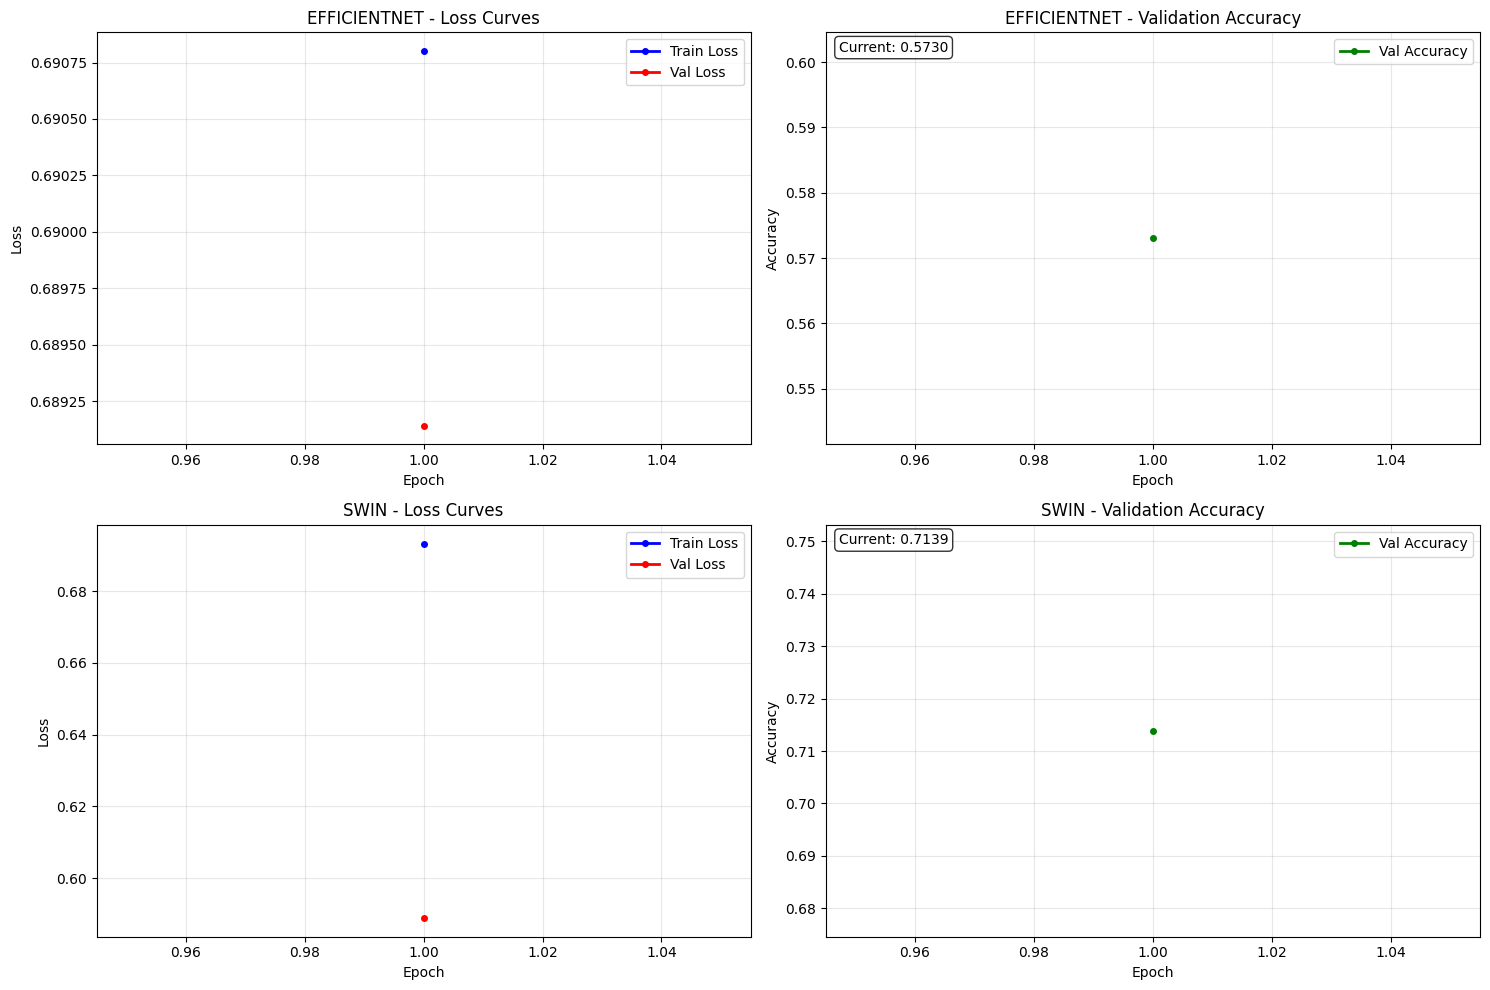


 EPOCH 1 SUMMARY:
  EFFICIENTNET: Train Loss=0.690801, Val Acc=0.5730, Val Loss=0.689143
  SWIN: Train Loss=0.693277, Val Acc=0.7139, Val Loss=0.588898

EPOCH 2/30

Training EFFICIENTNET...
   Warmup LR: 2.80e-07
   Training...
Epoch 2 | Batch 100/667 | Loss 0.678663
Epoch 2 | Batch 200/667 | Loss 0.695933
Epoch 2 | Batch 300/667 | Loss 0.680208
Epoch 2 | Batch 400/667 | Loss 0.678681
Epoch 2 | Batch 500/667 | Loss 0.694887
Epoch 2 | Batch 600/667 | Loss 0.691505
   Validating...
Validation class distribution: 1400/2684 positives
   EFFICIENTNET Results:
     Train Loss: 0.681916
     Val Accuracy: 0.7370 (73.70%)
     Val Loss: 0.667759

Training SWIN...
   Current Learning Rates:
    swin_backbone: 0.00e+00
    swin_head: 3.00e-05
   Training...
Epoch 2 | Batch 100/667 | Loss 0.571380
Epoch 2 | Batch 200/667 | Loss 0.579998
Epoch 2 | Batch 300/667 | Loss 0.652166
Epoch 2 | Batch 400/667 | Loss 0.619511
Epoch 2 | Batch 500/667 | Loss 0.727837
Epoch 2 | Batch 600/667 | Loss 0.633531
 

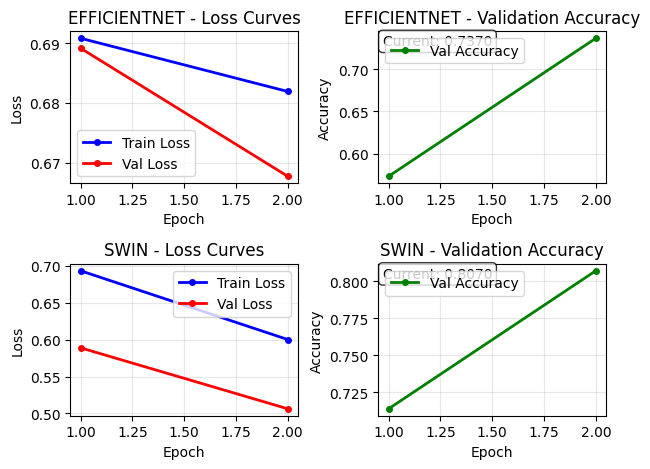


 EPOCH 2 SUMMARY:
  EFFICIENTNET: Train Loss=0.681916, Val Acc=0.7370, Val Loss=0.667759
  SWIN: Train Loss=0.600121, Val Acc=0.8070, Val Loss=0.506277

EPOCH 3/30

Training EFFICIENTNET...
   Warmup LR: 4.60e-07
   Training...
Epoch 3 | Batch 100/667 | Loss 0.670546
Epoch 3 | Batch 200/667 | Loss 0.644970
Epoch 3 | Batch 300/667 | Loss 0.633804
Epoch 3 | Batch 400/667 | Loss 0.631885
Epoch 3 | Batch 500/667 | Loss 0.639449
Epoch 3 | Batch 600/667 | Loss 0.694523
   Validating...
Validation class distribution: 1400/2684 positives
   EFFICIENTNET Results:
     Train Loss: 0.647649
     Val Accuracy: 0.8003 (80.03%)
     Val Loss: 0.614283

Training SWIN...
   Current Learning Rates:
    swin_backbone: 0.00e+00
    swin_head: 3.00e-05
   Training...
Epoch 3 | Batch 100/667 | Loss 0.432547
Epoch 3 | Batch 200/667 | Loss 0.642510
Epoch 3 | Batch 300/667 | Loss 0.544007
Epoch 3 | Batch 400/667 | Loss 0.410466
Epoch 3 | Batch 500/667 | Loss 0.415133
Epoch 3 | Batch 600/667 | Loss 0.404778
 

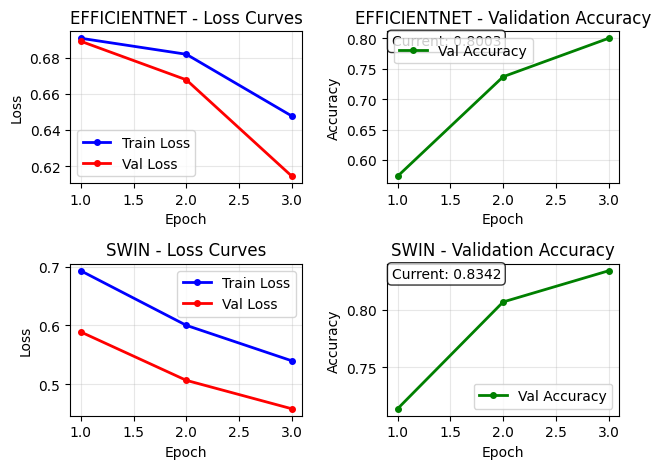


 EPOCH 3 SUMMARY:
  EFFICIENTNET: Train Loss=0.647649, Val Acc=0.8003, Val Loss=0.614283
  SWIN: Train Loss=0.539544, Val Acc=0.8342, Val Loss=0.457707

EPOCH 4/30

Training EFFICIENTNET...
   Warmup LR: 6.40e-07
   Training...
Epoch 4 | Batch 100/667 | Loss 0.588542
Epoch 4 | Batch 200/667 | Loss 0.569339
Epoch 4 | Batch 300/667 | Loss 0.550955
Epoch 4 | Batch 400/667 | Loss 0.712852
Epoch 4 | Batch 500/667 | Loss 0.589819
Epoch 4 | Batch 600/667 | Loss 0.579068
   Validating...
Validation class distribution: 1400/2684 positives
   EFFICIENTNET Results:
     Train Loss: 0.578196
     Val Accuracy: 0.8383 (83.83%)
     Val Loss: 0.535965

Training SWIN...
   Current Learning Rates:
    swin_backbone: 0.00e+00
    swin_head: 3.00e-05
   Training...
Epoch 4 | Batch 100/667 | Loss 0.625806
Epoch 4 | Batch 200/667 | Loss 0.468214
Epoch 4 | Batch 300/667 | Loss 0.627804
Epoch 4 | Batch 400/667 | Loss 0.533335
Epoch 4 | Batch 500/667 | Loss 0.477996
Epoch 4 | Batch 600/667 | Loss 0.365368
 

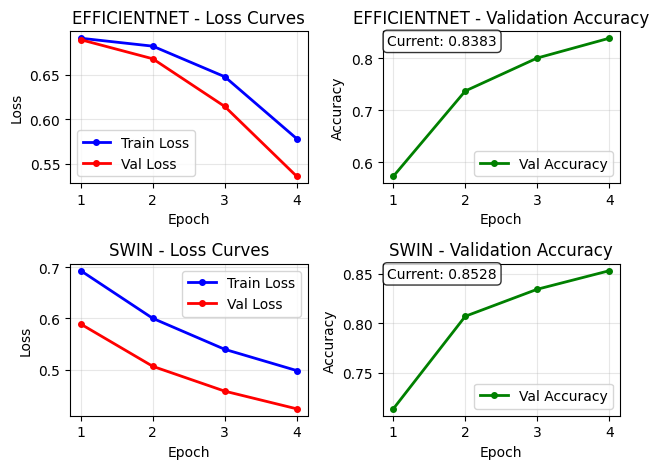


 EPOCH 4 SUMMARY:
  EFFICIENTNET: Train Loss=0.578196, Val Acc=0.8383, Val Loss=0.535965
  SWIN: Train Loss=0.498004, Val Acc=0.8528, Val Loss=0.423172

EPOCH 5/30

Training EFFICIENTNET...
   Warmup LR: 8.20e-07
   Training...
Epoch 5 | Batch 100/667 | Loss 0.484631
Epoch 5 | Batch 200/667 | Loss 0.531142
Epoch 5 | Batch 300/667 | Loss 0.462257
Epoch 5 | Batch 400/667 | Loss 0.680195
Epoch 5 | Batch 500/667 | Loss 0.493928
Epoch 5 | Batch 600/667 | Loss 0.569297
   Validating...
Validation class distribution: 1400/2684 positives
   EFFICIENTNET Results:
     Train Loss: 0.515960
     Val Accuracy: 0.8428 (84.28%)
     Val Loss: 0.502741

Training SWIN...
   Current Learning Rates:
    swin_backbone: 0.00e+00
    swin_head: 3.00e-05
   Training...
Epoch 5 | Batch 100/667 | Loss 0.475344
Epoch 5 | Batch 200/667 | Loss 0.465663
Epoch 5 | Batch 300/667 | Loss 0.447480
Epoch 5 | Batch 400/667 | Loss 0.528252
Epoch 5 | Batch 500/667 | Loss 0.635818
Epoch 5 | Batch 600/667 | Loss 0.413834
 

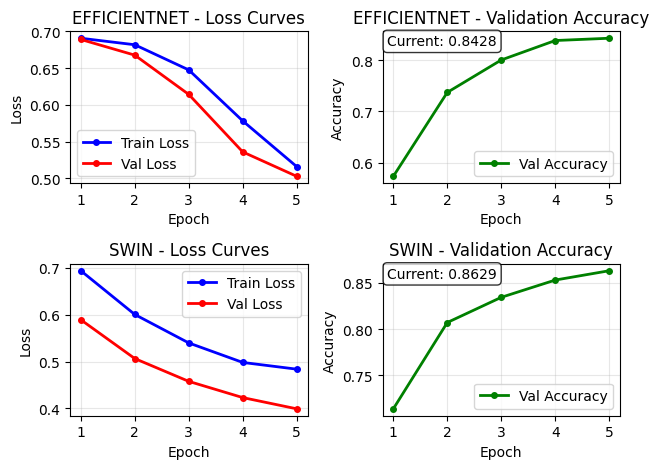


 EPOCH 5 SUMMARY:
  EFFICIENTNET: Train Loss=0.515960, Val Acc=0.8428, Val Loss=0.502741
  SWIN: Train Loss=0.483702, Val Acc=0.8629, Val Loss=0.399266

EPOCH 6/30

 Epoch 6: Unfreezing Swin Transformer backbone
  Unfrozen 171 parameters
   Backbone LR: 1.00e-05
   Head LR: 1.00e-04
  Cosine scheduler initialized for 25 epochs

Training EFFICIENTNET...
   Warmup complete! Switching to ReduceLROnPlateau...
   Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 6 | Batch 100/667 | Loss 0.430954
Epoch 6 | Batch 200/667 | Loss 0.484010
Epoch 6 | Batch 300/667 | Loss 0.447975
Epoch 6 | Batch 400/667 | Loss 0.454398
Epoch 6 | Batch 500/667 | Loss 0.388152
Epoch 6 | Batch 600/667 | Loss 0.551833
   Validating...
Validation class distribution: 1400/2684 positives
   EFFICIENTNET Results:
     Train Loss: 0.463720
     Val Accuracy: 0.8584 (85.84%)
     Val Loss: 0.435425

Training SWIN...
   Current Learning Rates:
    swin_backbone: 1.00e-05
    swin_head: 1.00e-05
   Training...
Epoch 6 | Batch 100/667 | Loss 0.093913
Epoch 6 | Batch 200/667 | Loss 0.247567
Epoch 6 | Batch 300/667 | Loss 0.252343
Epoch 6 | Batch 400/667 | Loss 0.314439
Epoch 6 | Batch 500/667 | Loss 0.557189
Epoch 6 | Batch 600/667 | Loss 0.222900
   Validating...
Validation class distribution: 1400/2684 positives
   SWIN Results:
     Train Loss: 0.271832
     Val Accuracy: 0.9169 (91.69%)
     Val Loss: 0.245154


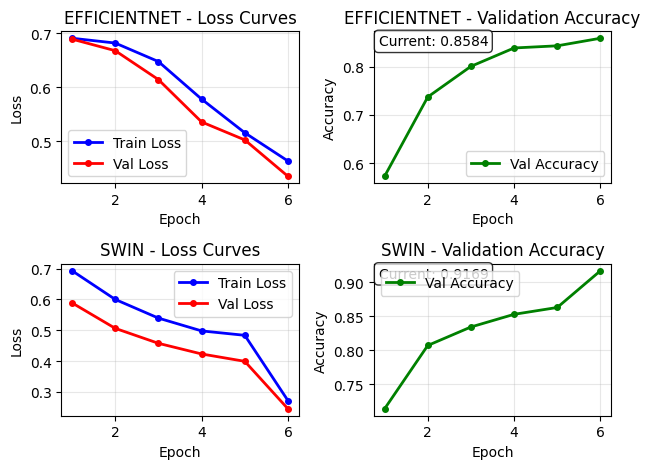


 EPOCH 6 SUMMARY:
  EFFICIENTNET: Train Loss=0.463720, Val Acc=0.8584, Val Loss=0.435425
  SWIN: Train Loss=0.271832, Val Acc=0.9169, Val Loss=0.245154

EPOCH 7/30

Training EFFICIENTNET...
   Training...
Epoch 7 | Batch 100/667 | Loss 0.452146
Epoch 7 | Batch 200/667 | Loss 0.397797
Epoch 7 | Batch 300/667 | Loss 0.395278
Epoch 7 | Batch 400/667 | Loss 0.359059
Epoch 7 | Batch 500/667 | Loss 0.417849
Epoch 7 | Batch 600/667 | Loss 0.370869
   Validating...
Validation class distribution: 1400/2684 positives
   EFFICIENTNET Results:
     Train Loss: 0.416864
     Val Accuracy: 0.8767 (87.67%)
     Val Loss: 0.373955

Training SWIN...
   Current Learning Rates:
    swin_backbone: 1.00e-05
    swin_head: 1.00e-05
   Training...
Epoch 7 | Batch 100/667 | Loss 0.184025
Epoch 7 | Batch 200/667 | Loss 0.173803
Epoch 7 | Batch 300/667 | Loss 0.093573
Epoch 7 | Batch 400/667 | Loss 0.354115
Epoch 7 | Batch 500/667 | Loss 0.045125
Epoch 7 | Batch 600/667 | Loss 0.121299
   Validating...
Validat

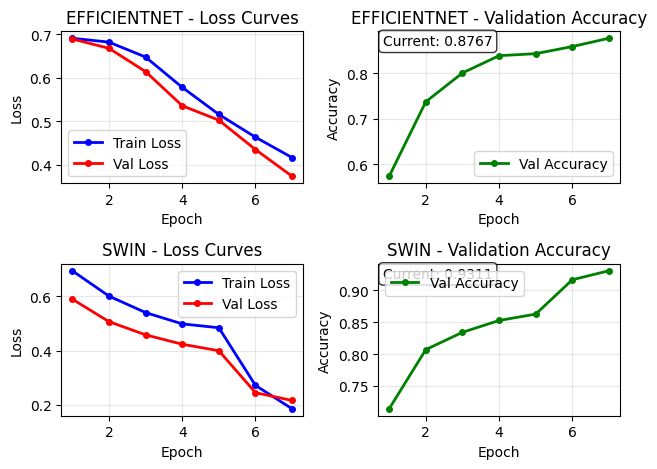


 EPOCH 7 SUMMARY:
  EFFICIENTNET: Train Loss=0.416864, Val Acc=0.8767, Val Loss=0.373955
  SWIN: Train Loss=0.185810, Val Acc=0.9311, Val Loss=0.216402

EPOCH 8/30

Training EFFICIENTNET...
   Training...
Epoch 8 | Batch 100/667 | Loss 0.345499
Epoch 8 | Batch 200/667 | Loss 0.382536
Epoch 8 | Batch 300/667 | Loss 0.348906
Epoch 8 | Batch 400/667 | Loss 0.407363
Epoch 8 | Batch 500/667 | Loss 0.348090
Epoch 8 | Batch 600/667 | Loss 0.301320
   Validating...
Validation class distribution: 1400/2684 positives
   EFFICIENTNET Results:
     Train Loss: 0.376870
     Val Accuracy: 0.8737 (87.37%)
     Val Loss: 0.346261

Training SWIN...
   Current Learning Rates:
    swin_backbone: 9.96e-06
    swin_head: 9.96e-05
   Training...
Epoch 8 | Batch 100/667 | Loss 0.059850
Epoch 8 | Batch 200/667 | Loss 0.182619
Epoch 8 | Batch 300/667 | Loss 0.288295
Epoch 8 | Batch 400/667 | Loss 0.049035
Epoch 8 | Batch 500/667 | Loss 0.101338
Epoch 8 | Batch 600/667 | Loss 0.046291
   Validating...
Validat

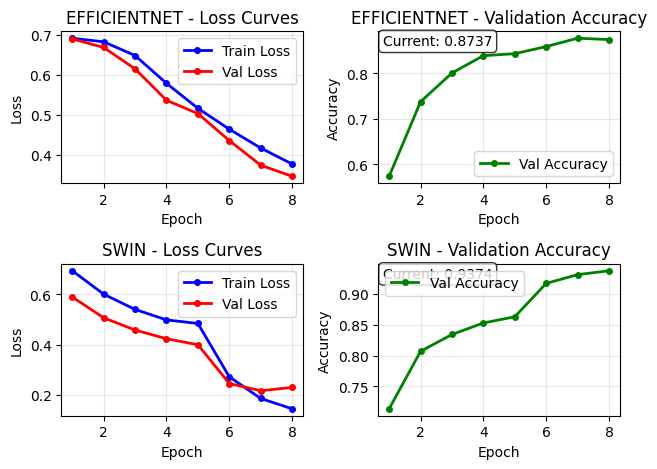


 EPOCH 8 SUMMARY:
  EFFICIENTNET: Train Loss=0.376870, Val Acc=0.8737, Val Loss=0.346261
  SWIN: Train Loss=0.144671, Val Acc=0.9374, Val Loss=0.229686

EPOCH 9/30

Training EFFICIENTNET...
   Training...
Epoch 9 | Batch 100/667 | Loss 0.225354
Epoch 9 | Batch 200/667 | Loss 0.364457
Epoch 9 | Batch 300/667 | Loss 0.281073
Epoch 9 | Batch 400/667 | Loss 0.619458
Epoch 9 | Batch 500/667 | Loss 0.267460
Epoch 9 | Batch 600/667 | Loss 0.300107
   Validating...
Validation class distribution: 1400/2684 positives
   EFFICIENTNET Results:
     Train Loss: 0.348855
     Val Accuracy: 0.8860 (88.60%)
     Val Loss: 0.328958

Training SWIN...
   Current Learning Rates:
    swin_backbone: 9.84e-06
    swin_head: 9.84e-05
   Training...
Epoch 9 | Batch 100/667 | Loss 0.086356
Epoch 9 | Batch 200/667 | Loss 0.043842
Epoch 9 | Batch 300/667 | Loss 0.070982
Epoch 9 | Batch 400/667 | Loss 0.261967
Epoch 9 | Batch 500/667 | Loss 0.040787
Epoch 9 | Batch 600/667 | Loss 0.361277
   Validating...
Validat

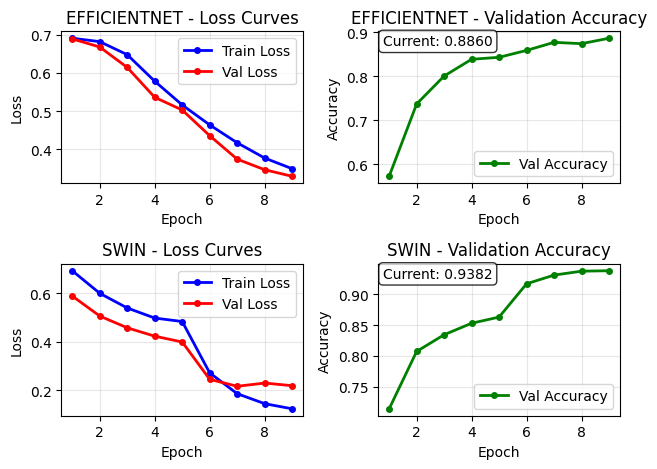


 EPOCH 9 SUMMARY:
  EFFICIENTNET: Train Loss=0.348855, Val Acc=0.8860, Val Loss=0.328958
  SWIN: Train Loss=0.123375, Val Acc=0.9382, Val Loss=0.218814

EPOCH 10/30

Training EFFICIENTNET...
   Training...
Epoch 10 | Batch 100/667 | Loss 0.255741
Epoch 10 | Batch 200/667 | Loss 0.587025
Epoch 10 | Batch 300/667 | Loss 0.320171
Epoch 10 | Batch 400/667 | Loss 0.353017
Epoch 10 | Batch 500/667 | Loss 0.251203
Epoch 10 | Batch 600/667 | Loss 0.263565
   Validating...
Validation class distribution: 1400/2684 positives
   EFFICIENTNET Results:
     Train Loss: 0.318494
     Val Accuracy: 0.8879 (88.79%)
     Val Loss: 0.310410

Training SWIN...
   Current Learning Rates:
    swin_backbone: 9.65e-06
    swin_head: 9.65e-05
   Training...
Epoch 10 | Batch 100/667 | Loss 0.056006
Epoch 10 | Batch 200/667 | Loss 0.279666
Epoch 10 | Batch 300/667 | Loss 0.094956
Epoch 10 | Batch 400/667 | Loss 0.059476
Epoch 10 | Batch 500/667 | Loss 0.226193
Epoch 10 | Batch 600/667 | Loss 0.044189
   Validati

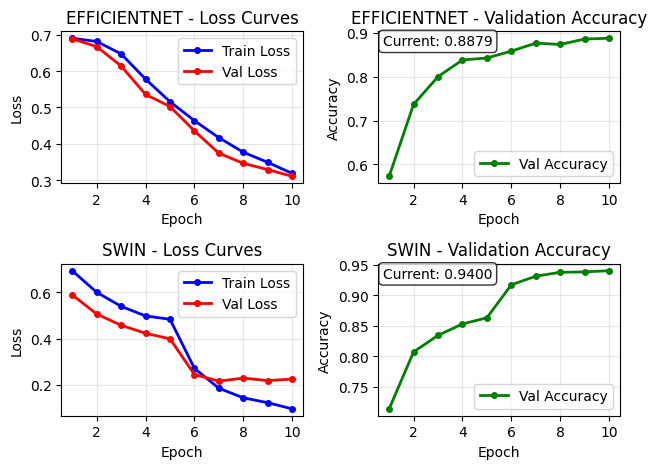


 EPOCH 10 SUMMARY:
  EFFICIENTNET: Train Loss=0.318494, Val Acc=0.8879, Val Loss=0.310410
  SWIN: Train Loss=0.096968, Val Acc=0.9400, Val Loss=0.225434

EPOCH 11/30

Training EFFICIENTNET...
   Training...
Epoch 11 | Batch 100/667 | Loss 0.339362
Epoch 11 | Batch 200/667 | Loss 0.246323
Epoch 11 | Batch 300/667 | Loss 0.312625
Epoch 11 | Batch 400/667 | Loss 0.242766
Epoch 11 | Batch 500/667 | Loss 0.262327
Epoch 11 | Batch 600/667 | Loss 0.140055
   Validating...
Validation class distribution: 1400/2684 positives
   EFFICIENTNET Results:
     Train Loss: 0.297815
     Val Accuracy: 0.8797 (87.97%)
     Val Loss: 0.308489

Training SWIN...
   Current Learning Rates:
    swin_backbone: 9.39e-06
    swin_head: 9.38e-05
   Training...
Epoch 11 | Batch 100/667 | Loss 0.036467
Epoch 11 | Batch 200/667 | Loss 0.038252
Epoch 11 | Batch 300/667 | Loss 0.127874
Epoch 11 | Batch 400/667 | Loss 0.036952
Epoch 11 | Batch 500/667 | Loss 0.338848
Epoch 11 | Batch 600/667 | Loss 0.033892
   Validat

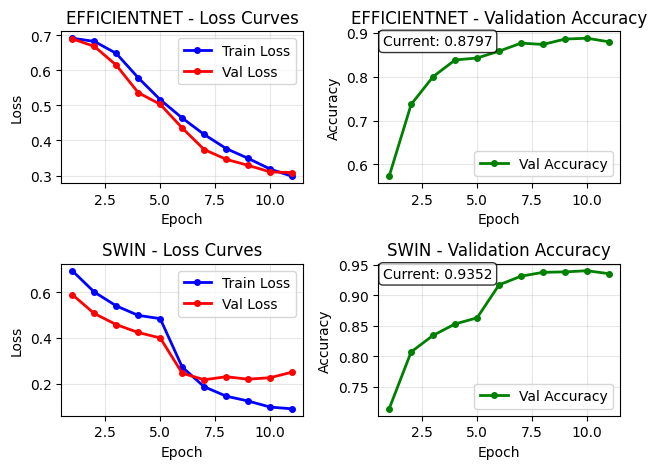


 EPOCH 11 SUMMARY:
  EFFICIENTNET: Train Loss=0.297815, Val Acc=0.8797, Val Loss=0.308489
  SWIN: Train Loss=0.089293, Val Acc=0.9352, Val Loss=0.249803

EPOCH 12/30

Training EFFICIENTNET...
   Training...
Epoch 12 | Batch 100/667 | Loss 0.343991
Epoch 12 | Batch 200/667 | Loss 0.457109
Epoch 12 | Batch 300/667 | Loss 0.195651
Epoch 12 | Batch 400/667 | Loss 0.512112
Epoch 12 | Batch 500/667 | Loss 0.234425
Epoch 12 | Batch 600/667 | Loss 0.183710
   Validating...
Validation class distribution: 1400/2684 positives
   EFFICIENTNET Results:
     Train Loss: 0.281591
     Val Accuracy: 0.8908 (89.08%)
     Val Loss: 0.296344

Training SWIN...
   Current Learning Rates:
    swin_backbone: 9.05e-06
    swin_head: 9.05e-05
   Training...
Epoch 12 | Batch 100/667 | Loss 0.043069
Epoch 12 | Batch 200/667 | Loss 0.194544
Epoch 12 | Batch 300/667 | Loss 0.037042
Epoch 12 | Batch 400/667 | Loss 0.034292
Epoch 12 | Batch 500/667 | Loss 0.036249
Epoch 12 | Batch 600/667 | Loss 0.050026
   Validat

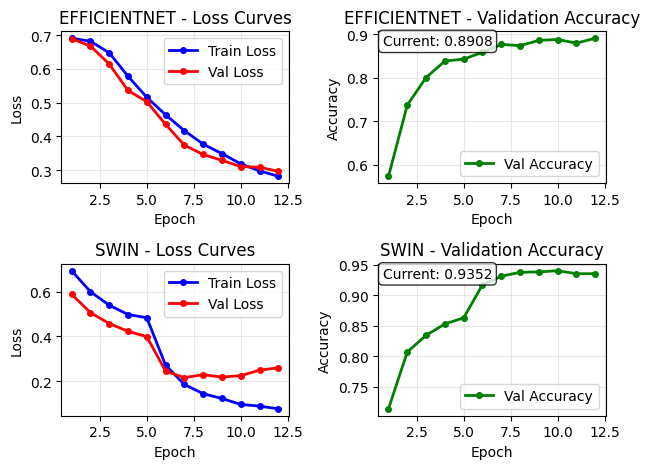


 EPOCH 12 SUMMARY:
  EFFICIENTNET: Train Loss=0.281591, Val Acc=0.8908, Val Loss=0.296344
  SWIN: Train Loss=0.077268, Val Acc=0.9352, Val Loss=0.260079

EPOCH 13/30

Training EFFICIENTNET...
   Training...
Epoch 13 | Batch 100/667 | Loss 0.209108
Epoch 13 | Batch 200/667 | Loss 0.189961
Epoch 13 | Batch 300/667 | Loss 0.459288
Epoch 13 | Batch 400/667 | Loss 0.167982
Epoch 13 | Batch 500/667 | Loss 0.300185
Epoch 13 | Batch 600/667 | Loss 0.157887
   Validating...
Validation class distribution: 1400/2684 positives
   EFFICIENTNET Results:
     Train Loss: 0.257946
     Val Accuracy: 0.8923 (89.23%)
     Val Loss: 0.288429

Training SWIN...
   Current Learning Rates:
    swin_backbone: 8.66e-06
    swin_head: 8.65e-05
   Training...
Epoch 13 | Batch 100/667 | Loss 0.103187
Epoch 13 | Batch 200/667 | Loss 0.037147
Epoch 13 | Batch 300/667 | Loss 0.270109
Epoch 13 | Batch 400/667 | Loss 0.040591
Epoch 13 | Batch 500/667 | Loss 0.034618
Epoch 13 | Batch 600/667 | Loss 0.045428
   Validat

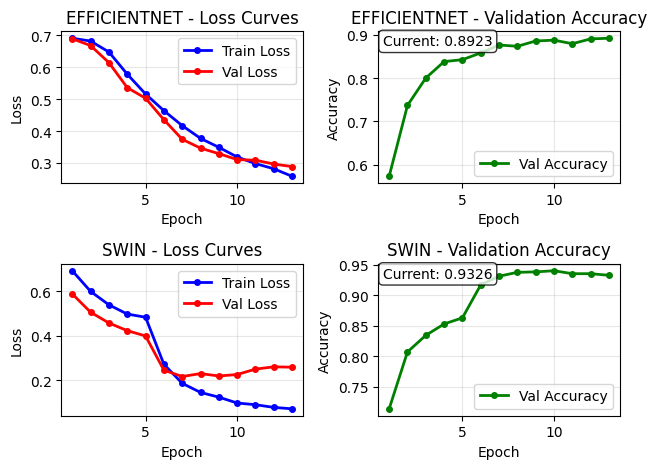


 EPOCH 13 SUMMARY:
  EFFICIENTNET: Train Loss=0.257946, Val Acc=0.8923, Val Loss=0.288429
  SWIN: Train Loss=0.070831, Val Acc=0.9326, Val Loss=0.258468

EPOCH 14/30

Training EFFICIENTNET...
   Training...
Epoch 14 | Batch 100/667 | Loss 0.212521
Epoch 14 | Batch 200/667 | Loss 0.313845
Epoch 14 | Batch 300/667 | Loss 0.137318
Epoch 14 | Batch 400/667 | Loss 0.226079
Epoch 14 | Batch 500/667 | Loss 0.513798
Epoch 14 | Batch 600/667 | Loss 0.148524
   Validating...
Validation class distribution: 1400/2684 positives
   EFFICIENTNET Results:
     Train Loss: 0.244923
     Val Accuracy: 0.8934 (89.34%)
     Val Loss: 0.284090

Training SWIN...
   Current Learning Rates:
    swin_backbone: 8.21e-06
    swin_head: 8.19e-05
   Training...
Epoch 14 | Batch 100/667 | Loss 0.152686
Epoch 14 | Batch 200/667 | Loss 0.039769
Epoch 14 | Batch 300/667 | Loss 0.052726
Epoch 14 | Batch 400/667 | Loss 0.035548
Epoch 14 | Batch 500/667 | Loss 0.033853
Epoch 14 | Batch 600/667 | Loss 0.035408
   Validat

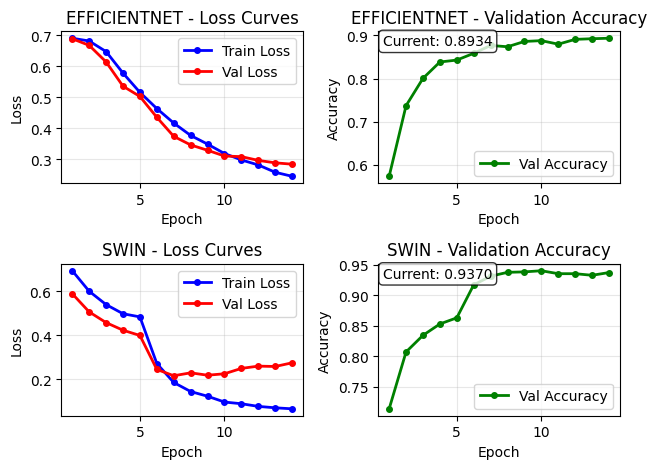


 EPOCH 14 SUMMARY:
  EFFICIENTNET: Train Loss=0.244923, Val Acc=0.8934, Val Loss=0.284090
  SWIN: Train Loss=0.066232, Val Acc=0.9370, Val Loss=0.275179

EPOCH 15/30

Training EFFICIENTNET...
   Training...
Epoch 15 | Batch 100/667 | Loss 0.289818
Epoch 15 | Batch 200/667 | Loss 0.178375
Epoch 15 | Batch 300/667 | Loss 0.349119
Epoch 15 | Batch 400/667 | Loss 0.327854
Epoch 15 | Batch 500/667 | Loss 0.145095
Epoch 15 | Batch 600/667 | Loss 0.190003
   Validating...
Validation class distribution: 1400/2684 positives
   EFFICIENTNET Results:
     Train Loss: 0.238337
     Val Accuracy: 0.8864 (88.64%)
     Val Loss: 0.294285

Training SWIN...
   Current Learning Rates:
    swin_backbone: 7.70e-06
    swin_head: 7.68e-05
   Training...
Epoch 15 | Batch 100/667 | Loss 0.036522
Epoch 15 | Batch 200/667 | Loss 0.039719
Epoch 15 | Batch 300/667 | Loss 0.035219
Epoch 15 | Batch 400/667 | Loss 0.090945
Epoch 15 | Batch 500/667 | Loss 0.034782
Epoch 15 | Batch 600/667 | Loss 0.034621
   Validat

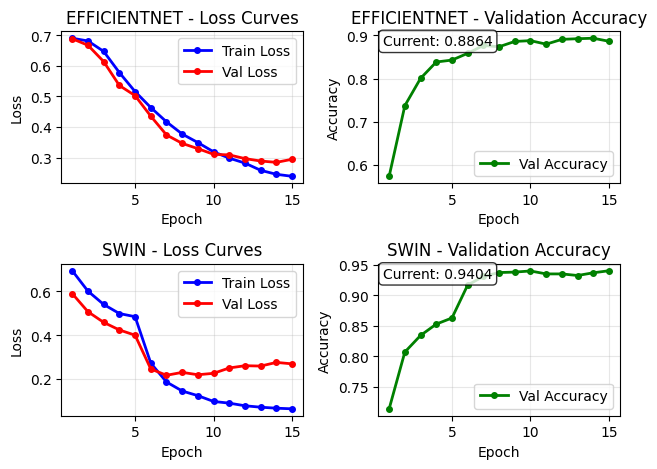


 EPOCH 15 SUMMARY:
  EFFICIENTNET: Train Loss=0.238337, Val Acc=0.8864, Val Loss=0.294285
  SWIN: Train Loss=0.063435, Val Acc=0.9404, Val Loss=0.268492

EPOCH 16/30

Training EFFICIENTNET...
   Training...
Epoch 16 | Batch 100/667 | Loss 0.203484
Epoch 16 | Batch 200/667 | Loss 0.521443
Epoch 16 | Batch 300/667 | Loss 0.105492
Epoch 16 | Batch 400/667 | Loss 0.241787
Epoch 16 | Batch 500/667 | Loss 0.257465
Epoch 16 | Batch 600/667 | Loss 0.142709
   Validating...
Validation class distribution: 1400/2684 positives
   EFFICIENTNET Results:
     Train Loss: 0.235086
     Val Accuracy: 0.8901 (89.01%)
     Val Loss: 0.292590

Training SWIN...
   Current Learning Rates:
    swin_backbone: 7.16e-06
    swin_head: 7.13e-05
   Training...
Epoch 16 | Batch 100/667 | Loss 0.034332
Epoch 16 | Batch 200/667 | Loss 0.035133
Epoch 16 | Batch 300/667 | Loss 0.033250
Epoch 16 | Batch 400/667 | Loss 0.034203
Epoch 16 | Batch 500/667 | Loss 0.036424
Epoch 16 | Batch 600/667 | Loss 0.139794
   Validat

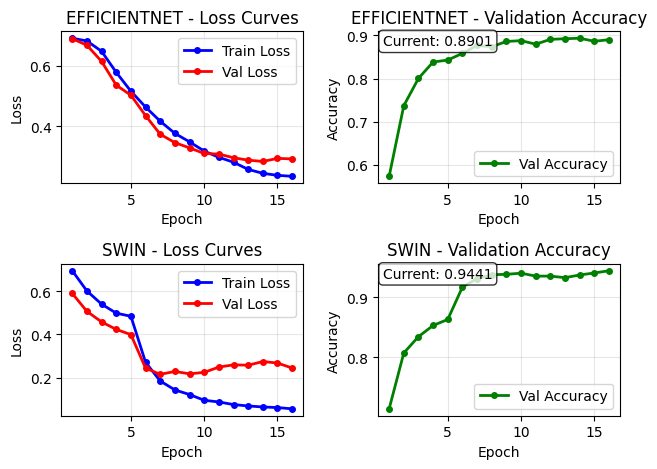


 EPOCH 16 SUMMARY:
  EFFICIENTNET: Train Loss=0.235086, Val Acc=0.8901, Val Loss=0.292590
  SWIN: Train Loss=0.057679, Val Acc=0.9441, Val Loss=0.245355

EPOCH 17/30

Training EFFICIENTNET...
   Training...
Epoch 17 | Batch 100/667 | Loss 0.184932
Epoch 17 | Batch 200/667 | Loss 0.384727
Epoch 17 | Batch 300/667 | Loss 0.156451
Epoch 17 | Batch 400/667 | Loss 0.094014
Epoch 17 | Batch 500/667 | Loss 0.274278
Epoch 17 | Batch 600/667 | Loss 0.173602
   Validating...
Validation class distribution: 1400/2684 positives
   EFFICIENTNET Results:
     Train Loss: 0.220190
     Val Accuracy: 0.8964 (89.64%)
     Val Loss: 0.284720

Training SWIN...
   Current Learning Rates:
    swin_backbone: 6.58e-06
    swin_head: 6.55e-05
   Training...
Epoch 17 | Batch 100/667 | Loss 0.038184
Epoch 17 | Batch 200/667 | Loss 0.035533
Epoch 17 | Batch 300/667 | Loss 0.443371
Epoch 17 | Batch 400/667 | Loss 0.033860
Epoch 17 | Batch 500/667 | Loss 0.034317
Epoch 17 | Batch 600/667 | Loss 0.033369
   Validat

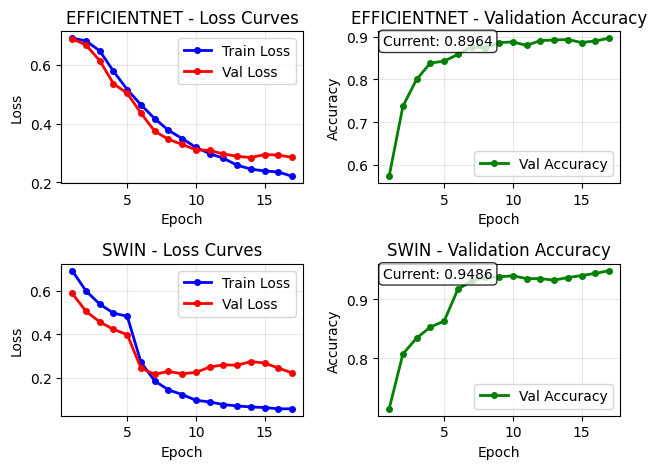


 EPOCH 17 SUMMARY:
  EFFICIENTNET: Train Loss=0.220190, Val Acc=0.8964, Val Loss=0.284720
  SWIN: Train Loss=0.057630, Val Acc=0.9486, Val Loss=0.222834

EPOCH 18/30

Training EFFICIENTNET...
   Training...
Epoch 18 | Batch 100/667 | Loss 0.133172
Epoch 18 | Batch 200/667 | Loss 0.211028
Epoch 18 | Batch 300/667 | Loss 0.408825
Epoch 18 | Batch 400/667 | Loss 0.075692
Epoch 18 | Batch 500/667 | Loss 0.130947
Epoch 18 | Batch 600/667 | Loss 0.183532
   Validating...
Validation class distribution: 1400/2684 positives
   EFFICIENTNET Results:
     Train Loss: 0.216773
     Val Accuracy: 0.8994 (89.94%)
     Val Loss: 0.273133

Training SWIN...
   Current Learning Rates:
    swin_backbone: 5.98e-06
    swin_head: 5.94e-05
   Training...
Epoch 18 | Batch 100/667 | Loss 0.055895
Epoch 18 | Batch 200/667 | Loss 0.032677
Epoch 18 | Batch 300/667 | Loss 0.034039
Epoch 18 | Batch 400/667 | Loss 0.034403
Epoch 18 | Batch 500/667 | Loss 0.052857
Epoch 18 | Batch 600/667 | Loss 0.037362
   Validat

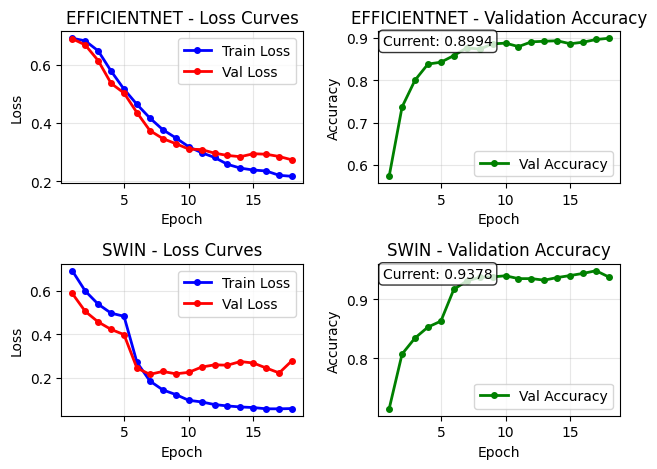


 EPOCH 18 SUMMARY:
  EFFICIENTNET: Train Loss=0.216773, Val Acc=0.8994, Val Loss=0.273133
  SWIN: Train Loss=0.058891, Val Acc=0.9378, Val Loss=0.280033

EPOCH 19/30

Training EFFICIENTNET...
   Training...
Epoch 19 | Batch 100/667 | Loss 0.160888
Epoch 19 | Batch 200/667 | Loss 0.076935
Epoch 19 | Batch 300/667 | Loss 0.069066
Epoch 19 | Batch 400/667 | Loss 0.081107
Epoch 19 | Batch 500/667 | Loss 0.468955
Epoch 19 | Batch 600/667 | Loss 0.092554
   Validating...
Validation class distribution: 1400/2684 positives
   EFFICIENTNET Results:
     Train Loss: 0.202561
     Val Accuracy: 0.8942 (89.42%)
     Val Loss: 0.293652

Training SWIN...
   Current Learning Rates:
    swin_backbone: 5.36e-06
    swin_head: 5.32e-05
   Training...
Epoch 19 | Batch 100/667 | Loss 0.034481
Epoch 19 | Batch 200/667 | Loss 0.313189
Epoch 19 | Batch 300/667 | Loss 0.036234
Epoch 19 | Batch 400/667 | Loss 0.089430
Epoch 19 | Batch 500/667 | Loss 0.034586
Epoch 19 | Batch 600/667 | Loss 0.033507
   Validat

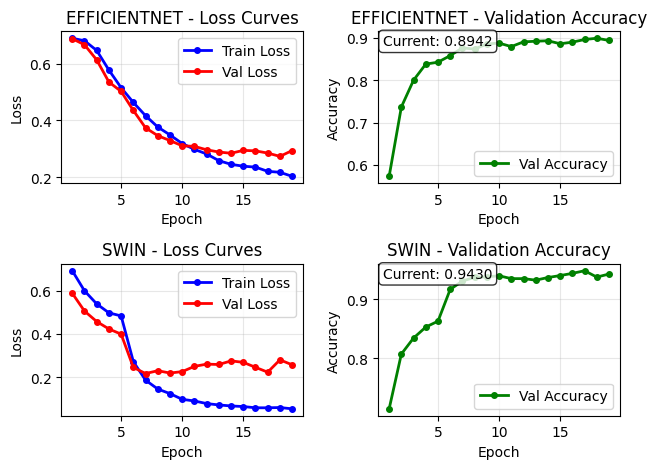


 EPOCH 19 SUMMARY:
  EFFICIENTNET: Train Loss=0.202561, Val Acc=0.8942, Val Loss=0.293652
  SWIN: Train Loss=0.052910, Val Acc=0.9430, Val Loss=0.257020

EPOCH 20/30

Training EFFICIENTNET...
   Training...
Epoch 20 | Batch 100/667 | Loss 0.154557
Epoch 20 | Batch 200/667 | Loss 0.082908
Epoch 20 | Batch 300/667 | Loss 0.084245
Epoch 20 | Batch 400/667 | Loss 0.361639
Epoch 20 | Batch 500/667 | Loss 0.189218
Epoch 20 | Batch 600/667 | Loss 0.133315
   Validating...
Validation class distribution: 1400/2684 positives
   EFFICIENTNET Results:
     Train Loss: 0.195682
     Val Accuracy: 0.9035 (90.35%)
     Val Loss: 0.299974

Training SWIN...
   Current Learning Rates:
    swin_backbone: 4.74e-06
    swin_head: 4.69e-05
   Training...
Epoch 20 | Batch 100/667 | Loss 0.035958
Epoch 20 | Batch 200/667 | Loss 0.034988
Epoch 20 | Batch 300/667 | Loss 0.034147
Epoch 20 | Batch 400/667 | Loss 0.034623
Epoch 20 | Batch 500/667 | Loss 0.034587
Epoch 20 | Batch 600/667 | Loss 0.035876
   Validat

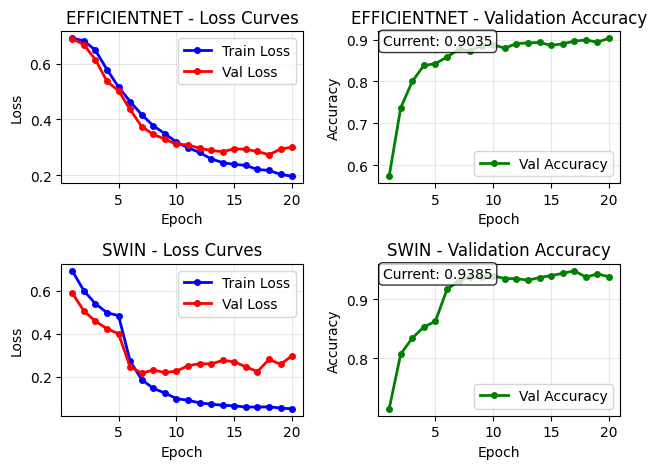


 EPOCH 20 SUMMARY:
  EFFICIENTNET: Train Loss=0.195682, Val Acc=0.9035, Val Loss=0.299974
  SWIN: Train Loss=0.049385, Val Acc=0.9385, Val Loss=0.297032

EPOCH 21/30

Training EFFICIENTNET...
   Training...
Epoch 21 | Batch 100/667 | Loss 0.109860
Epoch 21 | Batch 200/667 | Loss 0.190971
Epoch 21 | Batch 300/667 | Loss 0.235260
Epoch 21 | Batch 400/667 | Loss 0.113686
Epoch 21 | Batch 500/667 | Loss 0.111475
Epoch 21 | Batch 600/667 | Loss 0.072357
   Validating...
Validation class distribution: 1400/2684 positives
   EFFICIENTNET Results:
     Train Loss: 0.191633
     Val Accuracy: 0.9106 (91.06%)
     Val Loss: 0.275235

Training SWIN...
   Current Learning Rates:
    swin_backbone: 4.12e-06
    swin_head: 4.07e-05
   Training...
Epoch 21 | Batch 100/667 | Loss 0.037632
Epoch 21 | Batch 200/667 | Loss 0.033738
Epoch 21 | Batch 300/667 | Loss 0.167587
Epoch 21 | Batch 400/667 | Loss 0.033976
Epoch 21 | Batch 500/667 | Loss 0.034173
Epoch 21 | Batch 600/667 | Loss 0.034427
   Validat

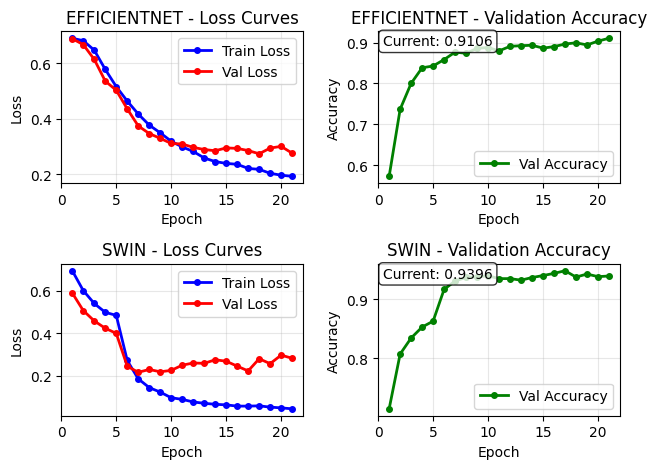


 EPOCH 21 SUMMARY:
  EFFICIENTNET: Train Loss=0.191633, Val Acc=0.9106, Val Loss=0.275235
  SWIN: Train Loss=0.044953, Val Acc=0.9396, Val Loss=0.282294

EPOCH 22/30

Training EFFICIENTNET...
   Training...
Epoch 22 | Batch 100/667 | Loss 0.237881
Epoch 22 | Batch 200/667 | Loss 0.094028
Epoch 22 | Batch 300/667 | Loss 0.081275
Epoch 22 | Batch 400/667 | Loss 0.265230
Epoch 22 | Batch 500/667 | Loss 0.205520
Epoch 22 | Batch 600/667 | Loss 0.079228
   Validating...
Validation class distribution: 1400/2684 positives
   EFFICIENTNET Results:
     Train Loss: 0.180155
     Val Accuracy: 0.8957 (89.57%)
     Val Loss: 0.300934

Training SWIN...
   Current Learning Rates:
    swin_backbone: 3.52e-06
    swin_head: 3.46e-05
   Training...
Epoch 22 | Batch 100/667 | Loss 0.033995
Epoch 22 | Batch 200/667 | Loss 0.034540
Epoch 22 | Batch 300/667 | Loss 0.035066
Epoch 22 | Batch 400/667 | Loss 0.033770
Epoch 22 | Batch 500/667 | Loss 0.032855
Epoch 22 | Batch 600/667 | Loss 0.051680
   Validat

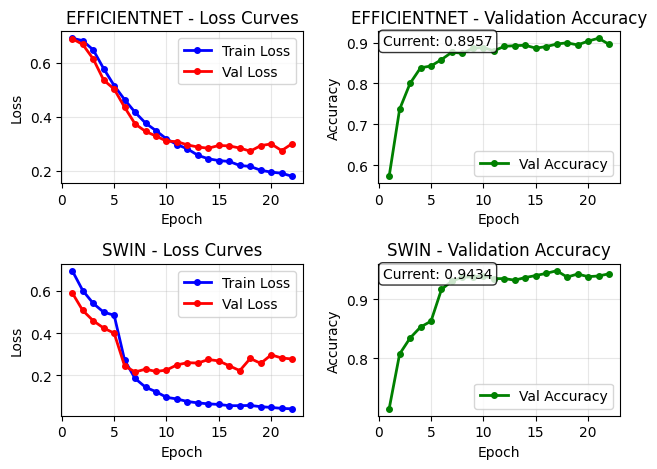


 EPOCH 22 SUMMARY:
  EFFICIENTNET: Train Loss=0.180155, Val Acc=0.8957, Val Loss=0.300934
  SWIN: Train Loss=0.042875, Val Acc=0.9434, Val Loss=0.277553

EPOCH 23/30

Training EFFICIENTNET...
   Training...
Epoch 23 | Batch 100/667 | Loss 0.109537
Epoch 23 | Batch 200/667 | Loss 0.219614
Epoch 23 | Batch 300/667 | Loss 0.668498
Epoch 23 | Batch 400/667 | Loss 0.078247
Epoch 23 | Batch 500/667 | Loss 0.383670
Epoch 23 | Batch 600/667 | Loss 0.071718
   Validating...
Validation class distribution: 1400/2684 positives
   EFFICIENTNET Results:
     Train Loss: 0.183695
     Val Accuracy: 0.9050 (90.50%)
     Val Loss: 0.292650

Training SWIN...
   Current Learning Rates:
    swin_backbone: 2.94e-06
    swin_head: 2.88e-05
   Training...
Epoch 23 | Batch 100/667 | Loss 0.183024
Epoch 23 | Batch 200/667 | Loss 0.033111
Epoch 23 | Batch 300/667 | Loss 0.034900
Epoch 23 | Batch 400/667 | Loss 0.038973
Epoch 23 | Batch 500/667 | Loss 0.035596
Epoch 23 | Batch 600/667 | Loss 0.038450
   Validat

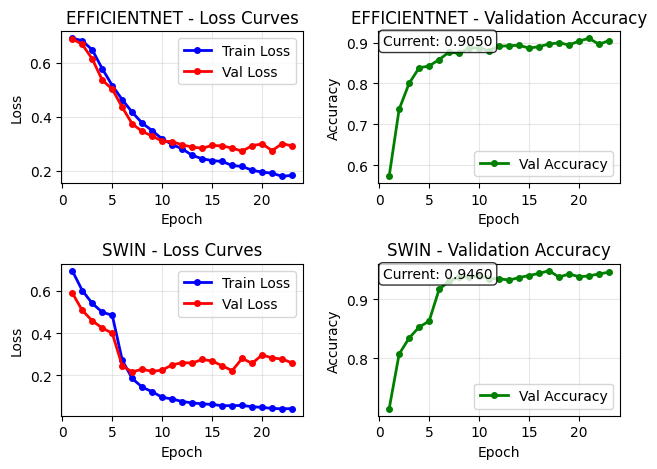


 EPOCH 23 SUMMARY:
  EFFICIENTNET: Train Loss=0.183695, Val Acc=0.9050, Val Loss=0.292650
  SWIN: Train Loss=0.044087, Val Acc=0.9460, Val Loss=0.258921

EPOCH 24/30

Training EFFICIENTNET...
   Training...
Epoch 24 | Batch 100/667 | Loss 0.369605
Epoch 24 | Batch 200/667 | Loss 0.127240
Epoch 24 | Batch 300/667 | Loss 0.131343
Epoch 24 | Batch 400/667 | Loss 1.171543
Epoch 24 | Batch 500/667 | Loss 0.334444
Epoch 24 | Batch 600/667 | Loss 0.097505
   Validating...
Validation class distribution: 1400/2684 positives
   EFFICIENTNET Results:
     Train Loss: 0.191766
     Val Accuracy: 0.8774 (87.74%)
     Val Loss: 0.368082

Training SWIN...
   Current Learning Rates:
    swin_backbone: 2.40e-06
    swin_head: 2.33e-05
   Training...
Epoch 24 | Batch 100/667 | Loss 0.034597
Epoch 24 | Batch 200/667 | Loss 0.032813
Epoch 24 | Batch 300/667 | Loss 0.033913
Epoch 24 | Batch 400/667 | Loss 0.039190
Epoch 24 | Batch 500/667 | Loss 0.034637
Epoch 24 | Batch 600/667 | Loss 0.032098
   Validat

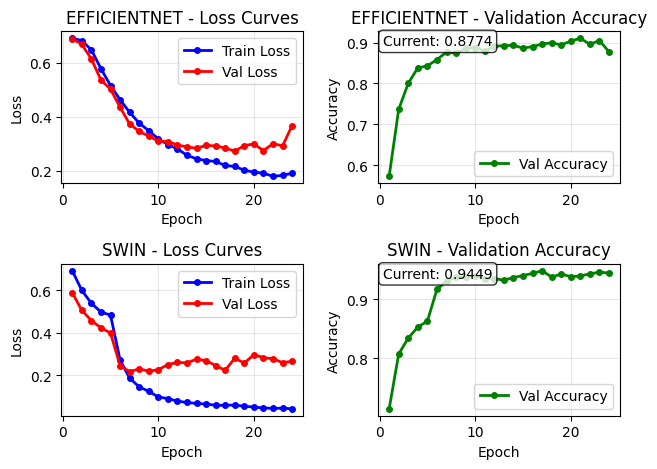


 EPOCH 24 SUMMARY:
  EFFICIENTNET: Train Loss=0.191766, Val Acc=0.8774, Val Loss=0.368082
  SWIN: Train Loss=0.040950, Val Acc=0.9449, Val Loss=0.265796

EPOCH 25/30

Training EFFICIENTNET...
   Training...
Epoch 25 | Batch 100/667 | Loss 0.218886
Epoch 25 | Batch 200/667 | Loss 0.106849
Epoch 25 | Batch 300/667 | Loss 0.071101
Epoch 25 | Batch 400/667 | Loss 0.077155
Epoch 25 | Batch 500/667 | Loss 0.239346
Epoch 25 | Batch 600/667 | Loss 0.093293
   Validating...
Validation class distribution: 1400/2684 positives
   EFFICIENTNET Results:
     Train Loss: 0.177207
     Val Accuracy: 0.8916 (89.16%)
     Val Loss: 0.323252

Training SWIN...
   Current Learning Rates:
    swin_backbone: 1.89e-06
    swin_head: 1.82e-05
   Training...
Epoch 25 | Batch 100/667 | Loss 0.033446
Epoch 25 | Batch 200/667 | Loss 0.032868
Epoch 25 | Batch 300/667 | Loss 0.032118
Epoch 25 | Batch 400/667 | Loss 0.033238
Epoch 25 | Batch 500/667 | Loss 0.145423
Epoch 25 | Batch 600/667 | Loss 0.093688
   Validat

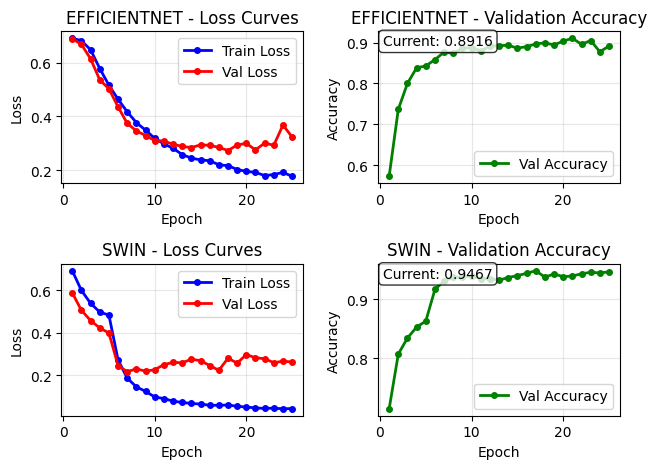


 EPOCH 25 SUMMARY:
  EFFICIENTNET: Train Loss=0.177207, Val Acc=0.8916, Val Loss=0.323252
  SWIN: Train Loss=0.042365, Val Acc=0.9467, Val Loss=0.262359

EPOCH 26/30

Training EFFICIENTNET...
   Training...
Epoch 26 | Batch 100/667 | Loss 0.235601
Epoch 26 | Batch 200/667 | Loss 0.083337
Epoch 26 | Batch 300/667 | Loss 0.068965
Epoch 26 | Batch 400/667 | Loss 0.103896
Epoch 26 | Batch 500/667 | Loss 0.136728
Epoch 26 | Batch 600/667 | Loss 0.221448
   Validating...
Validation class distribution: 1400/2684 positives
   EFFICIENTNET Results:
     Train Loss: 0.164466
     Val Accuracy: 0.8975 (89.75%)
     Val Loss: 0.316924

Training SWIN...
   Current Learning Rates:
    swin_backbone: 1.44e-06
    swin_head: 1.36e-05
   Training...
Epoch 26 | Batch 100/667 | Loss 0.032370
Epoch 26 | Batch 200/667 | Loss 0.033326
Epoch 26 | Batch 300/667 | Loss 0.037151
Epoch 26 | Batch 400/667 | Loss 0.033713
Epoch 26 | Batch 500/667 | Loss 0.032106
Epoch 26 | Batch 600/667 | Loss 0.047677
   Validat

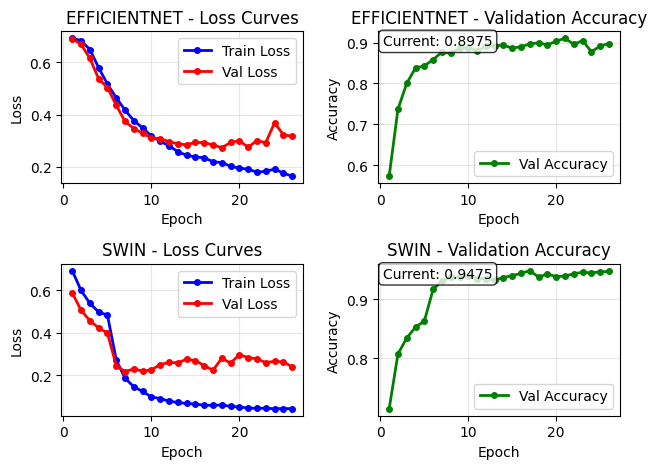


 EPOCH 26 SUMMARY:
  EFFICIENTNET: Train Loss=0.164466, Val Acc=0.8975, Val Loss=0.316924
  SWIN: Train Loss=0.041626, Val Acc=0.9475, Val Loss=0.239667

EPOCH 27/30

Training EFFICIENTNET...
   Training...
Epoch 27 | Batch 100/667 | Loss 0.076640
Epoch 27 | Batch 200/667 | Loss 0.105198
Epoch 27 | Batch 300/667 | Loss 0.237643
Epoch 27 | Batch 400/667 | Loss 0.137469
Epoch 27 | Batch 500/667 | Loss 0.093053
Epoch 27 | Batch 600/667 | Loss 0.135922
   Validating...
Validation class distribution: 1400/2684 positives
   EFFICIENTNET Results:
     Train Loss: 0.156120
     Val Accuracy: 0.9013 (90.13%)
     Val Loss: 0.311719

Training SWIN...
   Current Learning Rates:
    swin_backbone: 1.05e-06
    swin_head: 9.64e-06
   Training...
Epoch 27 | Batch 100/667 | Loss 0.033052
Epoch 27 | Batch 200/667 | Loss 0.033542
Epoch 27 | Batch 300/667 | Loss 0.071188
Epoch 27 | Batch 400/667 | Loss 0.032886
Epoch 27 | Batch 500/667 | Loss 0.040032
Epoch 27 | Batch 600/667 | Loss 0.033935
   Validat

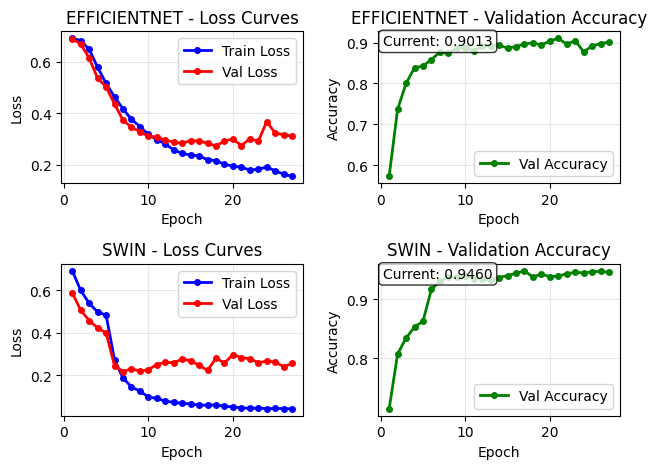


 EPOCH 27 SUMMARY:
  EFFICIENTNET: Train Loss=0.156120, Val Acc=0.9013, Val Loss=0.311719
  SWIN: Train Loss=0.040492, Val Acc=0.9460, Val Loss=0.255135

EPOCH 28/30

Training EFFICIENTNET...
   Training...
Epoch 28 | Batch 100/667 | Loss 0.172173
Epoch 28 | Batch 200/667 | Loss 0.076710
Epoch 28 | Batch 300/667 | Loss 0.319609
Epoch 28 | Batch 400/667 | Loss 0.111283
Epoch 28 | Batch 500/667 | Loss 0.556607
Epoch 28 | Batch 600/667 | Loss 0.279654
   Validating...
Validation class distribution: 1400/2684 positives
   EFFICIENTNET Results:
     Train Loss: 0.158438
     Val Accuracy: 0.9016 (90.16%)
     Val Loss: 0.328743

Training SWIN...
   Current Learning Rates:
    swin_backbone: 7.12e-07
    swin_head: 6.28e-06
   Training...
Epoch 28 | Batch 100/667 | Loss 0.035883
Epoch 28 | Batch 200/667 | Loss 0.032982
Epoch 28 | Batch 300/667 | Loss 0.032910
Epoch 28 | Batch 400/667 | Loss 0.037996
Epoch 28 | Batch 500/667 | Loss 0.033167
Epoch 28 | Batch 600/667 | Loss 0.033752
   Validat

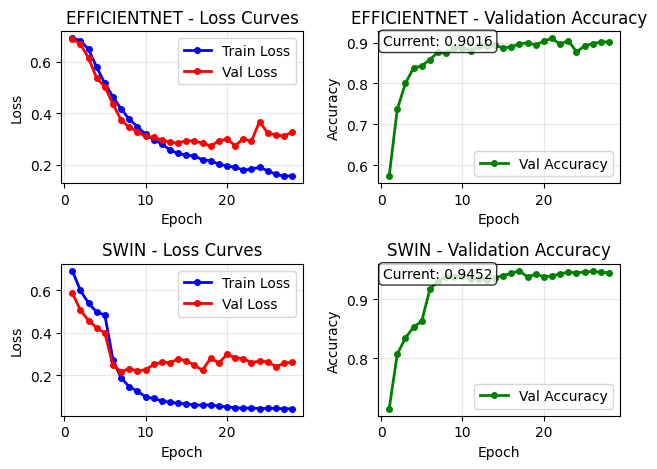


 EPOCH 28 SUMMARY:
  EFFICIENTNET: Train Loss=0.158438, Val Acc=0.9016, Val Loss=0.328743
  SWIN: Train Loss=0.040030, Val Acc=0.9452, Val Loss=0.261393

EPOCH 29/30

Training EFFICIENTNET...
   Training...
Epoch 29 | Batch 100/667 | Loss 0.063620
Epoch 29 | Batch 200/667 | Loss 0.077462
Epoch 29 | Batch 300/667 | Loss 0.232924
Epoch 29 | Batch 400/667 | Loss 0.061078
Epoch 29 | Batch 500/667 | Loss 0.066104
Epoch 29 | Batch 600/667 | Loss 0.074066
   Validating...
Validation class distribution: 1400/2684 positives
   EFFICIENTNET Results:
     Train Loss: 0.159381
     Val Accuracy: 0.9065 (90.65%)
     Val Loss: 0.288474

Training SWIN...
   Current Learning Rates:
    swin_backbone: 4.48e-07
    swin_head: 3.61e-06
   Training...
Epoch 29 | Batch 100/667 | Loss 0.032494
Epoch 29 | Batch 200/667 | Loss 0.047453
Epoch 29 | Batch 300/667 | Loss 0.033673
Epoch 29 | Batch 400/667 | Loss 0.033093
Epoch 29 | Batch 500/667 | Loss 0.034775
Epoch 29 | Batch 600/667 | Loss 0.034941
   Validat

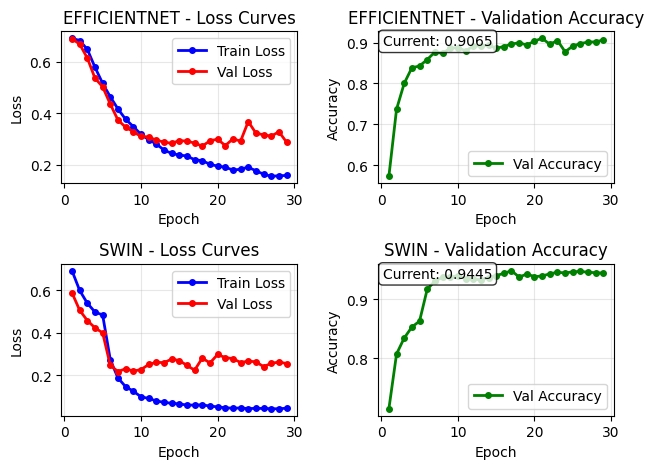


 EPOCH 29 SUMMARY:
  EFFICIENTNET: Train Loss=0.159381, Val Acc=0.9065, Val Loss=0.288474
  SWIN: Train Loss=0.043073, Val Acc=0.9445, Val Loss=0.254311

EPOCH 30/30

Training EFFICIENTNET...
   Training...
Epoch 30 | Batch 100/667 | Loss 0.106115
Epoch 30 | Batch 200/667 | Loss 0.103169
Epoch 30 | Batch 300/667 | Loss 0.059462
Epoch 30 | Batch 400/667 | Loss 0.735030
Epoch 30 | Batch 500/667 | Loss 0.261718
Epoch 30 | Batch 600/667 | Loss 0.106460
   Validating...
Validation class distribution: 1400/2684 positives
   EFFICIENTNET Results:
     Train Loss: 0.151246
     Val Accuracy: 0.9083 (90.83%)
     Val Loss: 0.293238

Training SWIN...
   Current Learning Rates:
    swin_backbone: 2.56e-07
    swin_head: 1.67e-06
   Training...
Epoch 30 | Batch 100/667 | Loss 0.033717
Epoch 30 | Batch 200/667 | Loss 0.042426
Epoch 30 | Batch 300/667 | Loss 0.033223
Epoch 30 | Batch 400/667 | Loss 0.032595
Epoch 30 | Batch 500/667 | Loss 0.032446
Epoch 30 | Batch 600/667 | Loss 0.033825
   Validat

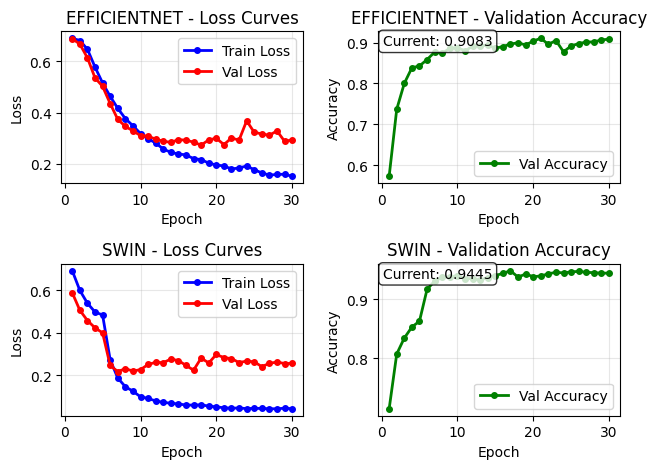


 EPOCH 30 SUMMARY:
  EFFICIENTNET: Train Loss=0.151246, Val Acc=0.9083, Val Loss=0.293238
  SWIN: Train Loss=0.040528, Val Acc=0.9445, Val Loss=0.254902

 TRAINING COMPLETED!

 Saving Training Results...
Detailed results saved to /kaggle/working/Training Data/efficientnet_results_2025-09-03_23-24-09_run2.json
Detailed results saved to /kaggle/working/Training Data/swin_results_2025-09-03_23-24-09_run2.json

 FINAL RESULTS SUMMARY:
--------------------------------------------------
EFFICIENTNET:
  Best Val Accuracy: 0.9106 (91.06%) at epoch 21
  Final Val Accuracy: 0.9083 (90.83%)
  Final Train Loss: 0.151246
  Final Val Loss: 0.293238

SWIN:
  Best Val Accuracy: 0.9486 (94.86%) at epoch 17
  Final Val Accuracy: 0.9445 (94.45%)
  Final Train Loss: 0.040528
  Final Val Loss: 0.254902

Training complete. All results saved.


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from datetime import datetime
from timm.scheduler import CosineLRScheduler

# Training Configuration
EPOCHS = 30
N_FREEZE_EPOCHS_SWIN = 5
PATIENCE_REDUCE_LR = 3

schedulers = {}

# Learning Rates
SWIN_LR_BACKBONE_FINETUNE = 1e-5
SWIN_LR_HEAD_FINETUNE = 1e-4
SWIN_LR_MIN_FINETUNE = 1e-7

# Global flags
SWIN_IS_UNFROZEN = False

train_metrics = {model_name: [] for model_name in models.keys()}
val_metrics = {model_name: [] for model_name in models.keys()}
val_loss_metrics = {model_name: [] for model_name in models.keys()}

print(f"\n--- Starting Training for {EPOCHS} Epochs ---")
print(f"Models to train: {list(models.keys())}")
print(f"Device: {device}")

# Initialize plotting
plt.ion()
fig = plt.figure(figsize=(15, 10))

# Initialize scheduler variables
efficientnet_plateau_scheduler = None
swin_finetune_scheduler_step_count = 0

schedulers = {}
loss_functions = {
    'efficientnet': nn.CrossEntropyLoss(label_smoothing=0.02),
    'swin': nn.CrossEntropyLoss(label_smoothing=0.01)
}

# Main Training Loop
for epoch in range(EPOCHS):
    print(f"\n{'='*60}")
    print(f"EPOCH {epoch + 1}/{EPOCHS}")
    print(f"{'='*60}")

    # Unfreeze Swin backbone if needed
    if 'swin' in models and epoch == N_FREEZE_EPOCHS_SWIN and not SWIN_IS_UNFROZEN:
        print(f"\n Epoch {epoch + 1}: Unfreezing Swin Transformer backbone")
        
        swin_model = models['swin']
        swin_optimizer = optimizers['swin']

        # Set all Swin parameters to trainable
        unfrozen_params = 0
        for param_name, param in swin_model.named_parameters():
            if not param.requires_grad:
                param.requires_grad = True
                unfrozen_params += 1

        print(f"  Unfrozen {unfrozen_params} parameters")

        # Update learning rates for different parameter groups
        if swin_optimizer:
            for param_group in swin_optimizer.param_groups:
                group_name = param_group.get('name', 'unknown_group')
                
                # Enable gradients for all parameters in this group
                for param in param_group['params']:
                    if not param.requires_grad:
                        param.requires_grad = True

                # Set appropriate learning rates
                if group_name == 'swin_backbone':
                    param_group['lr'] = SWIN_LR_BACKBONE_FINETUNE
                    print(f"   Backbone LR: {SWIN_LR_BACKBONE_FINETUNE:.2e}")
                elif group_name == 'swin_head':
                    param_group['lr'] = SWIN_LR_HEAD_FINETUNE
                    print(f"   Head LR: {SWIN_LR_HEAD_FINETUNE:.2e}")

            # Initialize CosineLR scheduler for remaining epochs
            remaining_epochs = EPOCHS - epoch
            schedulers['swin'] = CosineLRScheduler(
                swin_optimizer,
                t_initial=remaining_epochs,
                warmup_t=1,
                warmup_lr_init=SWIN_LR_BACKBONE_FINETUNE,
                lr_min=SWIN_LR_MIN_FINETUNE
            )
            SWIN_IS_UNFROZEN = True
            swin_finetune_scheduler_step_count = 0
            print(f"  Cosine scheduler initialized for {remaining_epochs} epochs")

    # Train each model for this epoch
    epoch_results = {}
    
    for model_name in models.keys():
        print(f"\nTraining {model_name.upper()}...")
        
        current_model = models[model_name]
        current_optimizer = optimizers[model_name]
        current_scheduler = schedulers.get(model_name)
        current_loss_fn = loss_functions[model_name]
        
        # Handle model-specific scheduling
        if model_name == 'efficientnet':
            if epoch < 5:
                # Warmup phase
                current_lr = warmup_scheduler.step(epoch)
                print(f"   Warmup LR: {current_lr:.2e}")
            elif epoch == 5:
                # Initialize plateau scheduler after warmup
                print("   Warmup complete! Switching to ReduceLROnPlateau...")
                efficientnet_plateau_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                    current_optimizer, 
                    mode='min', 
                    factor=0.5, 
                    patience=PATIENCE_REDUCE_LR, 
                    verbose=True
                )
                
        elif model_name == 'swin' and current_optimizer:
            print(f"   Current Learning Rates:")
            for i, param_group in enumerate(current_optimizer.param_groups):
                group_name = param_group.get('name', f'group_{i}')
                print(f"    {group_name}: {param_group['lr']:.2e}")

        # Training step
        print(f"   Training...")
        train_loss, _, _ = train_one_epoch(
            current_model,
            train_loader,
            current_optimizer,
            current_loss_fn,
            model_name,
            epoch,
            print_every=100
        )

        # Validation step
        print(f"   Validating...")
        val_accuracy, val_loss = eval_dataset_with_loss(
            current_model, 
            val_loader, 
            current_loss_fn
        )

        # Apply schedulers
        if model_name == 'efficientnet' and epoch >= 5 and efficientnet_plateau_scheduler:
            efficientnet_plateau_scheduler.step(train_loss)
        elif model_name == 'swin' and current_scheduler and SWIN_IS_UNFROZEN:
            current_scheduler.step(swin_finetune_scheduler_step_count)

        # Store results
        epoch_results[model_name] = {
            'train_loss': train_loss,
            'val_accuracy': val_accuracy,
            'val_loss': val_loss
        }
        
        # Append to metrics
        train_metrics[model_name].append(train_loss)
        val_metrics[model_name].append(val_accuracy)
        val_loss_metrics[model_name].append(val_loss)

        # Print results
        print(f"   {model_name.upper()} Results:")
        print(f"     Train Loss: {train_loss:.6f}")
        print(f"     Val Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
        print(f"     Val Loss: {val_loss:.6f}")

    # Update plots after all models are trained for this epoch
    plt.clf()
    
    num_models = len(models)
    for model_idx, model_name in enumerate(models.keys()):
        epochs_completed = list(range(1, len(train_metrics[model_name]) + 1))
        
        # Loss subplot
        plt.subplot(num_models, 2, model_idx * 2 + 1)
        plt.plot(epochs_completed, train_metrics[model_name], 'b-o', 
                label='Train Loss', linewidth=2, markersize=4)
        plt.plot(epochs_completed, val_loss_metrics[model_name], 'r-o', 
                label='Val Loss', linewidth=2, markersize=4)
        plt.title(f'{model_name.upper()} - Loss Curves')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Accuracy subplot
        plt.subplot(num_models, 2, model_idx * 2 + 2)
        plt.plot(epochs_completed, val_metrics[model_name], 'g-o', 
                label='Val Accuracy', linewidth=2, markersize=4)
        plt.title(f'{model_name.upper()} - Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Add current values as text
        if len(train_metrics[model_name]) > 0:
            current_acc = val_metrics[model_name][-1]
            plt.text(0.02, 0.98, f'Current: {current_acc:.4f}', 
                    transform=plt.gca().transAxes, 
                    verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.draw()
    plt.pause(0.1)
    
    # Print epoch summary
    print(f"\n EPOCH {epoch + 1} SUMMARY:")
    for model_name, results in epoch_results.items():
        print(f"  {model_name.upper()}: "
              f"Train Loss={results['train_loss']:.6f}, "
              f"Val Acc={results['val_accuracy']:.4f}, "
              f"Val Loss={results['val_loss']:.6f}")
    
    # Increment Swin scheduler step count
    if SWIN_IS_UNFROZEN:
        swin_finetune_scheduler_step_count += 1

print(f"\n{'='*60}")
print(" TRAINING COMPLETED!")
print(f"{'='*60}")

# Keep final plot displayed
plt.ioff()
plt.show()

# Save training results
print("\n Saving Training Results...")
current_timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

for model_name in models.keys():
    save_training_results(
        model_name,
        train_metrics[model_name],
        val_metrics[model_name],
        val_loss_metrics[model_name],
        current_timestamp
    )
    
    # Optional: Save model checkpoints
    # model_save_path = f"checkpoints/{model_name}_epoch{EPOCHS}_{current_timestamp}.pth"
    # torch.save(models[model_name].state_dict(), model_save_path)
    # print(f"Saved {model_name} checkpoint to {model_save_path}")

# Print final results summary
print(f"\n FINAL RESULTS SUMMARY:")
print("-" * 50)
for model_name in models.keys():
    if val_metrics[model_name]:
        best_acc = max(val_metrics[model_name])
        best_epoch = val_metrics[model_name].index(best_acc) + 1
        final_acc = val_metrics[model_name][-1]
        
        print(f"{model_name.upper()}:")
        print(f"  Best Val Accuracy: {best_acc:.4f} ({best_acc*100:.2f}%) at epoch {best_epoch}")
        print(f"  Final Val Accuracy: {final_acc:.4f} ({final_acc*100:.2f}%)")
        print(f"  Final Train Loss: {train_metrics[model_name][-1]:.6f}")
        print(f"  Final Val Loss: {val_loss_metrics[model_name][-1]:.6f}")
        print()

print("Training complete. All results saved.")


=== EFFICIENTNET ===
ROC‐AUC: 0.968   PR‐AUC (AP): 0.973
              precision    recall  f1-score   support

   authentic       0.92      0.89      0.90      1284
   imitation       0.90      0.93      0.91      1400

    accuracy                           0.91      2684
   macro avg       0.91      0.91      0.91      2684
weighted avg       0.91      0.91      0.91      2684



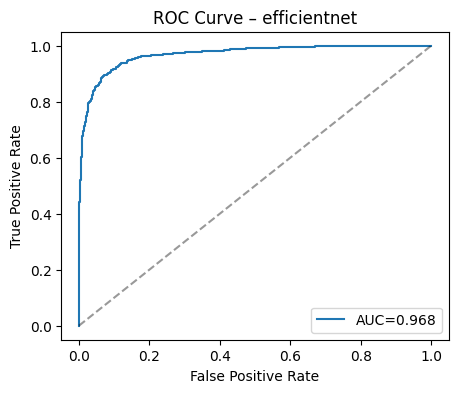

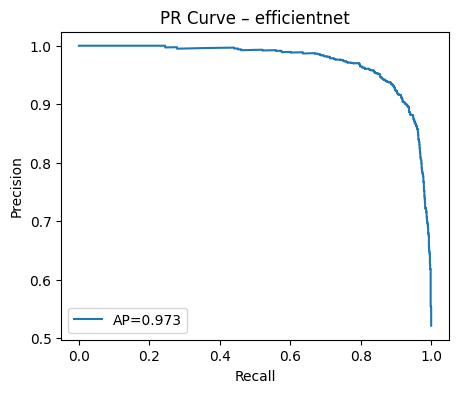


=== SWIN ===
ROC‐AUC: 0.979   PR‐AUC (AP): 0.972
              precision    recall  f1-score   support

   authentic       0.93      0.96      0.94      1284
   imitation       0.96      0.93      0.95      1400

    accuracy                           0.94      2684
   macro avg       0.94      0.95      0.94      2684
weighted avg       0.94      0.94      0.94      2684



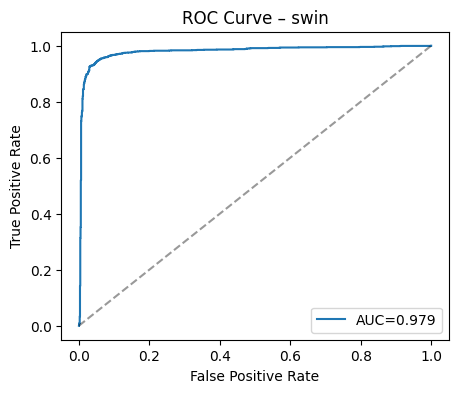

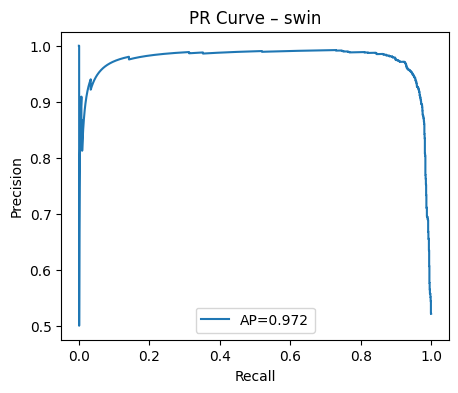

In [10]:
# 9. Detailed Evaluation Metrics & Curves
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    average_precision_score,
    roc_curve,
    precision_recall_curve
)
import matplotlib.pyplot as plt
import torch.nn.functional as F

device = torch.device("mps" if torch.backends.mps.is_available() else "cuda")

for name, model in models.items():
    model.to(device).eval()
    y_true, y_scores = [], []

    # Gather ground‐truth & predicted “imitation” probabilities
    with torch.no_grad():
        for x, y, _ in val_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            probs = F.softmax(logits, dim=1)[:, 1]      # P(imitation)
            y_true.extend(y.cpu().numpy().tolist())
            y_scores.extend(probs.cpu().numpy().tolist())

    # Binarize predictions at 0.5
    y_pred = [1 if p >= 0.5 else 0 for p in y_scores]

    # Compute metrics
    auc = roc_auc_score(y_true, y_scores)
    ap  = average_precision_score(y_true, y_scores)
    print(f"\n=== {name.upper()} ===")
    print(f"ROC‐AUC: {auc:.3f}   PR‐AUC (AP): {ap:.3f}")
    print(classification_report(
        y_true, y_pred,
        target_names=['authentic','imitation']
    ))

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f'AUC={auc:.3f}')
    plt.plot([0,1],[0,1],'k--',alpha=0.4)
    plt.title(f'ROC Curve – {name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(); plt.show()

    # Plot Precision–Recall Curve
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    plt.figure(figsize=(5,4))
    plt.plot(recall, precision, label=f'AP={ap:.3f}')
    plt.title(f'PR Curve – {name}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(); plt.show()

## 10. Plotting training metrics for each model
(reads CSV logs and plots train/val loss & val accuracy)

In [11]:
# 8) Painting‐level & Ensemble Evaluation
import numpy as np
import torch.nn.functional as F
from collections import defaultdict, Counter
from sklearn.metrics import classification_report, accuracy_score

device = torch.device("mps" if torch.backends.mps.is_available() else "cuda")
effnet_model = models['efficientnet'].to(device).eval()
swin_model   = models['swin'].to(device).eval()

# 1. Collect patch‐level data
painting_ids, true_labels = [], []
effnet_probs, swin_probs = [], []

for x, y, pid in val_loader:
    x = x.to(device)
    with torch.no_grad():
        e_logits = effnet_model(x)
        s_logits = swin_model(x)
        e_p = F.softmax(e_logits, dim=1)[:, 1].cpu().numpy()
        s_p = F.softmax(s_logits, dim=1)[:, 1].cpu().numpy()
    painting_ids.extend(pid.numpy())
    true_labels.extend(y.numpy())
    effnet_probs.extend(e_p)
    swin_probs.extend(s_p)

# 2. Aggregate per painting
paintings = defaultdict(list)
for pid, y, p1, p2 in zip(painting_ids, true_labels, effnet_probs, swin_probs):
    paintings[pid].append((y, p1, p2))

painting_true = []
paint_eff_major = []
paint_swin_major = []
paint_ens_major = []
paint_ens_avg = []

for pid, patches in paintings.items():
    y_true = patches[0][0]
    p1_list = [t[1] for t in patches]
    p2_list = [t[2] for t in patches]
    # votes at 0.5
    v1 = [int(p>=0.5) for p in p1_list]
    v2 = [int(p>=0.5) for p in p2_list]
    # ensemble avg‐prob votes
    avg_probs = [(a+b)/2 for a,b in zip(p1_list, p2_list)]
    v_avg = [int(p>=0.5) for p in avg_probs]

    painting_true.append(y_true)
    paint_eff_major.append(Counter(v1).most_common(1)[0][0])
    paint_swin_major.append(Counter(v2).most_common(1)[0][0])
    paint_ens_major.append(Counter(v_avg).most_common(1)[0][0])
    paint_ens_avg.append(int(np.mean(avg_probs)>=0.5))

# 3. Report metrics
print("=== Painting‐level Metrics ===")
for label, preds in [
    ("EffNet‐majority", paint_eff_major),
    ("Swin‐majority", paint_swin_major),
    ("Ensemble‐majority", paint_ens_major),
    ("Ensemble‐avgprob", paint_ens_avg),
]:
    print(f"\n{label}:")
    print("Accuracy:", accuracy_score(painting_true, preds))
    print(classification_report(
        painting_true, preds,
        target_names=['authentic','imitation']
    ))

=== Painting‐level Metrics ===

EffNet‐majority:
Accuracy: 0.9476439790575916
              precision    recall  f1-score   support

   authentic       0.94      0.94      0.94        87
   imitation       0.95      0.95      0.95       104

    accuracy                           0.95       191
   macro avg       0.95      0.95      0.95       191
weighted avg       0.95      0.95      0.95       191


Swin‐majority:
Accuracy: 0.9528795811518325
              precision    recall  f1-score   support

   authentic       0.92      0.98      0.95        87
   imitation       0.98      0.93      0.96       104

    accuracy                           0.95       191
   macro avg       0.95      0.95      0.95       191
weighted avg       0.95      0.95      0.95       191


Ensemble‐majority:
Accuracy: 0.9581151832460733
              precision    recall  f1-score   support

   authentic       0.93      0.98      0.96        87
   imitation       0.98      0.94      0.96       104

    accura

## 11. Saving metrics for each model


In [12]:
import os, json
import matplotlib.pyplot as plt

for model_name in models:
    json_path = f"/kaggle/working/Training Data/{model_name}_results_{now_str}.json"
    if not os.path.exists(json_path):
        print(f"No JSON results for {model_name} at {json_path}")
        continue

    # load our JSON list of dicts
    with open(json_path) as f:
        results = json.load(f)

    train_loss = results["training"]
    val_acc    = results["validation"]
    epochs     = list(range(1, len(train_loss)+1))

    plt.plot(epochs, train_loss, label="train loss")
    plt.plot(epochs, val_acc,    label="val acc")
    plt.legend()
    plt.show()

    #epochs = [r["epoch"] for r in results["training"]]
    #train_loss = [r["loss"]  for r in results["training"]]
    #val_acc    = [r["acc"]   for r in results["validation"]]

    fig, axes = plt.subplots(1, 2, figsize=(14,5))
    ax = axes[0]
    ax.plot(epochs, train_loss, '-o', label="Train Loss")
    ax.set_title(f"{model_name} – Train Loss")
    ax.set_xlabel("Epoch"); ax.set_ylabel("Loss")
    ax.grid(True)

    ax = axes[1]
    ax.plot(epochs, val_acc, '-o', color="green", label="Val Acc")
    ax.set_title(f"{model_name} – Val Accuracy")
    ax.set_xlabel("Epoch"); ax.set_ylabel("Accuracy")
    ax.grid(True)

    plt.tight_layout()
    plt.show()

No JSON results for efficientnet at /kaggle/working/Training Data/efficientnet_results_2025-09-03_20-07-56.json
No JSON results for swin at /kaggle/working/Training Data/swin_results_2025-09-03_20-07-56.json


## 12. Saving models

In [13]:
import os
import torch

# Ensure the save directory exists
for path in model_save_paths.values():
    os.makedirs(os.path.dirname(path), exist_ok=True)

# Save each model after training
for name, model in models.items():
    torch.save(model.state_dict(), model_save_paths[name])
    print(f"Model weights saved to {model_save_paths[name]}")

Model weights saved to /kaggle/working/model/efficientnet_b5_finetuned_2025-09-03_20-07-56_run1.pth
Model weights saved to /kaggle/working/model/swin_tiny_patch4_window7_224_finetuned_2025-09-03_20-07-56_run1.pth
